# Bimodal Churn Prediction: Integrating Structured Data and LLM-Based Text Embeddings

## Pre-requisites
- Setup a LiteLLM proxy instance (as mentioned at `.env.sample` file) to call LLM API embeddings

## 1. Problem Statement

Churn rate is a marketing metric that describes the number of customers who leave a business over a specific time period.
Understanding and detecting churn is the first step to retaining these customers and improving the company’s offerings.

**Goal** is to predict the churn for a website based on the features provided in the dataset. **Customer will EXIT(1) or NOT(0)**, and identify customers who are likely to leave so that we can retain then with some special offers on membership.

# 2. Data Dictionary <a id='dictionary'></a>

1. **age**  Represents the age of a customer
2. **gender** Represents the gender of a customer
3. **security_no** 	Represents a unique security number that is used to identify a person
4. **region_category** 	Represents the region that a customer belongs to 
5. **membership_category** 	Represents the category of the membership that a customer is using
6. **joining_date** 	Represents the date when a customer became a member 
7. **joined_through_referral** 	Represents whether a customer joined using any referral code or ID
8. **referral_id 	Represents** a referral ID
9. **preferred_offer_types** 	Represents the type of offer that a customer prefers
10. **medium_of_operation** 	Represents the medium of operation that a customer uses for transactions
11. **internet_option** 	Represents the type of internet service a customer uses
12. **last_visit_time** 	Represents the last time a customer visited the website
13. **days_since_last_login** 	Represents the no. of days since a customer last logged into the website
14. **avg_time_spent** 	Represents the average time spent by a customer on the website
15. **avg_transaction_value** 	Represents the average transaction value of a customer
16. **avg_frequency_login_days** 	Represents the no. of times a customer has logged in to the website
17. **points_in_wallet** 	Represents the points awarded to a customer on each transaction 
18. **used_special_discount** 	Represents whether a customer uses special discounts offered
19. **offer_application_preference** 	Represents whether a customer prefers offers 
20. **past_complaint** 	Represents whether a customer has raised any complaints 
21. **complaint_status** 	Represents whether the complaints raised by a customer was resolved 
22. **feedback** 	Represents the feedback provided by a customer
23. **churn_risk_score** 0 or 1 [Customer will Stay or Exit]

In [1]:
import warnings
warnings.filterwarnings('ignore')

## 3.0 Data Loading

In [2]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv("../../data/input/churn.csv.gz", compression="gzip", index_col=False)


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\ProgramData\miniconda3\envs\py3.11\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\tys\AppData\Roaming\Python\Python311\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\ProgramData\miniconda3\envs\py3.11\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_loop.start()
  F

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\ProgramData\miniconda3\envs\py3.11\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\tys\AppData\Roaming\Python\Python311\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\ProgramData\miniconda3\envs\py3.11\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_loop.start()
  F

AttributeError: _ARRAY_API not found

In [3]:
# Show basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36992 entries, 0 to 36991
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            36992 non-null  int64  
 1   age                           36992 non-null  int64  
 2   gender                        36992 non-null  object 
 3   security_no                   36992 non-null  object 
 4   region_category               31564 non-null  object 
 5   membership_category           36992 non-null  object 
 6   joining_date                  36992 non-null  object 
 7   joined_through_referral       36992 non-null  object 
 8   referral_id                   36992 non-null  object 
 9   preferred_offer_types         36704 non-null  object 
 10  medium_of_operation           36992 non-null  object 
 11  internet_option               36992 non-null  object 
 12  last_visit_time               36992 non-null  object 
 13  d

## 4.0 Data Synthesization

Objective: create LLM-generated synthentic feedback from existing `feedback` column with only 4 unique categories

In [4]:
# Generate synthentic feedback based on original feedback column with 4 unique categories

#import os

#from utils.prepare_llm_prompt import generate_prompt_for_synthentic_data
#from utils.prepare_synthentic_data import generate_text_from_series

#df2 = df.copy(deep=True)

#SYNTHENTIC_DATA_FILE = "../../data/processed/synthentic_feedback.csv.gz"
#if os.path.exists(SYNTHENTIC_DATA_FILE):
#    pass
#else:
    # 1) Prepare an prompt template from the columns in the dataset before we call the LLM api to 
    # create the synthentic feedback, The columns involved are:
        ## feedback, past_complaint, complaint_status, avg_time_spent, avg_transaction_value,
        ## avg_frequency_login_days, used_special_discount, offer_application_preference, 
        ## preferred_offer_types, last_visit_time, days_since_last_login, region_country, membership_category
#    df2['llm_prompt_for_synthentic_feedback'] = df2.apply(generate_prompt_for_synthentic_data, axis=1)
    
    # 2) Generate synthentic feedback based on original feedback column with 4 unique categories
#    synthentic_feedback = generate_text_from_series(
#            prompts_series=df2['llm_prompt_for_synthentic_feedback'],
#            system_prompt="You are a helpful assistant.",
#            max_tokens=500,
#            temperature=0.7,
#            max_workers=1,
#            output_csv_path=SYNTHENTIC_DATA_FILE
#        )
#    print(synthentic_feedback)
    
    # delete the llm prompt template prepared for LLM API call for each row
#    df2 = df2.drop(columns=['llm_prompt_for_synthentic_feedback'])

In [5]:
# Show the first few rows
df2 = df.copy(deep=True)
df2.head(3)

,id,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,preferred_offer_types,...,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score
0,1,18,F,XW0DQ7H,Village,Platinum Membership,17/8/2017,No,xxxxxxxx,Gift Vouchers/Coupons,...,300.63,53005.25,17,781.75,Yes,Yes,No,Not Applicable,Products always in Stock,0
1,2,32,F,5K0N3X1,City,Premium Membership,28/8/2017,?,CID21329,Gift Vouchers/Coupons,...,306.34,12838.38,10,NaN,Yes,No,Yes,Solved,Quality Customer Care,0
2,3,44,F,1F2TCL3,Town,No Membership,11/11/2016,Yes,CID12313,Gift Vouchers/Coupons,...,516.16,21027.00,22,500.69,No,Yes,Yes,Solved in Follow-up,Poor Website,1


In [6]:
synthentic_feedback_df = pd.read_csv("../../data/processed/synthentic_feedback.csv.gz", compression="gzip")

# Strip <response> and </response> tags in one line using regex
synthentic_feedback_df["feedback"] = synthentic_feedback_df["content"].str.replace(r"</?response>", "", regex=True)
synthentic_feedback_df = synthentic_feedback_df.drop(columns=["content"])
synthentic_feedback_df.head(3)

,id,feedback
0,0,I’m really impressed with how consistently you...
1,1,I’ve always appreciated the quality of custome...
2,2,I’ve been a regular user of your website for a...


In [7]:
df2

,id,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,preferred_offer_types,...,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score
0,1,18,F,XW0DQ7H,Village,Platinum Membership,17/8/2017,No,xxxxxxxx,Gift Vouchers/Coupons,...,300.630000,53005.25,17,781.750000,Yes,Yes,No,Not Applicable,Products always in Stock,0
1,2,32,F,5K0N3X1,City,Premium Membership,28/8/2017,?,CID21329,Gift Vouchers/Coupons,...,306.340000,12838.38,10,NaN,Yes,No,Yes,Solved,Quality Customer Care,0
2,3,44,F,1F2TCL3,Town,No Membership,11/11/2016,Yes,CID12313,Gift Vouchers/Coupons,...,516.160000,21027.00,22,500.690000,No,Yes,Yes,Solved in Follow-up,Poor Website,1
3,4,37,M,VJGJ33N,City,No Membership,29/10/2016,Yes,CID3793,Gift Vouchers/Coupons,...,53.270000,25239.56,6,567.660000,No,Yes,Yes,Unsolved,Poor Website,1
4,5,31,F,SVZXCWB,City,No Membership,12/9/2017,No,xxxxxxxx,Credit/Debit Card Offers,...,113.130000,24483.66,16,663.060000,No,Yes,Yes,Solved,Poor Website,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36987,36988,46,F,6F51HFO,NaN,Basic Membership,21/9/2017,No,xxxxxxxx,Credit/Debit Card Offers,...,-650.682758,27277.68,6,639.510000,No,Yes,Yes,No Information Available,No reason specified,1
36988,36989,29,F,21KSM8Y,Town,Basic Membership,27/6/2016,No,xxxxxxxx,Without Offers,...,-638.123421,11069.71,28,527.990000,Yes,No,No,Not Applicable,Poor Customer Service,1
36989,36990,23,F,XK1IM9H,NaN,Basic Membership,11/9/2016,Yes,CID3838,Gift Vouchers/Coupons,...,154.940000,38127.56,Error,680.470000,No,Yes,Yes,Unsolved,Poor Website,1
36990,36991,53,M,K6VTP1Z,Village,Platinum Membership,15/6/2017,No,xxxxxxxx,Gift Vouchers/Coupons,...,482.610000,2378.86,20,197.264414,Yes,Yes,No,Not Applicable,No reason specified,0


In [8]:
merged_df = pd.merge(df2.drop(columns=["feedback"]), 
                    synthentic_feedback_df, on='id', how='inner')
merged_df.head(3)

,id,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,preferred_offer_types,...,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,churn_risk_score,feedback
0,1,18,F,XW0DQ7H,Village,Platinum Membership,17/8/2017,No,xxxxxxxx,Gift Vouchers/Coupons,...,300.63,53005.25,17,781.75,Yes,Yes,No,Not Applicable,0,I’ve always appreciated the quality of custome...
1,2,32,F,5K0N3X1,City,Premium Membership,28/8/2017,?,CID21329,Gift Vouchers/Coupons,...,306.34,12838.38,10,NaN,Yes,No,Yes,Solved,0,I’ve been a regular user of your website for a...
2,3,44,F,1F2TCL3,Town,No Membership,11/11/2016,Yes,CID12313,Gift Vouchers/Coupons,...,516.16,21027.00,22,500.69,No,Yes,Yes,Solved in Follow-up,1,I've been frustrated with the website's perfor...


# 5.0 Exploratory Data Analysis  <a id='data_preparation'></a>

## 5.1 Data Dimensions

In [9]:
print(f'There are {merged_df.shape[0]} data points and {merged_df.shape[1]} features in the dataset')

There are 36991 data points and 24 features in the dataset


## 5.2 Data Types <a id='Data_Types'></a>

In [10]:
merged_df.dtypes

id                                int64
age                               int64
gender                           object
security_no                      object
region_category                  object
membership_category              object
joining_date                     object
joined_through_referral          object
referral_id                      object
preferred_offer_types            object
medium_of_operation              object
internet_option                  object
last_visit_time                  object
days_since_last_login             int64
avg_time_spent                  float64
avg_transaction_value           float64
avg_frequency_login_days         object
points_in_wallet                float64
used_special_discount            object
offer_application_preference     object
past_complaint                   object
complaint_status                 object
churn_risk_score                  int64
feedback                         object
dtype: object

In [11]:
merged_df.select_dtypes(include=[np.number]).head()

,id,age,days_since_last_login,avg_time_spent,avg_transaction_value,points_in_wallet,churn_risk_score
0,1,18,17,300.63,53005.25,781.75,0
1,2,32,16,306.34,12838.38,NaN,0
2,3,44,14,516.16,21027.00,500.69,1
3,4,37,11,53.27,25239.56,567.66,1
4,5,31,20,113.13,24483.66,663.06,1


In [12]:
merged_df.select_dtypes(include=['object']).head()

,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,preferred_offer_types,medium_of_operation,internet_option,last_visit_time,avg_frequency_login_days,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback
0,F,XW0DQ7H,Village,Platinum Membership,17/8/2017,No,xxxxxxxx,Gift Vouchers/Coupons,?,Wi-Fi,16:08:02,17,Yes,Yes,No,Not Applicable,I’ve always appreciated the quality of custome...
1,F,5K0N3X1,City,Premium Membership,28/8/2017,?,CID21329,Gift Vouchers/Coupons,Desktop,Mobile_Data,12:38:13,10,Yes,No,Yes,Solved,I’ve been a regular user of your website for a...
2,F,1F2TCL3,Town,No Membership,11/11/2016,Yes,CID12313,Gift Vouchers/Coupons,Desktop,Wi-Fi,22:53:21,22,No,Yes,Yes,Solved in Follow-up,I've been frustrated with the website's perfor...
3,M,VJGJ33N,City,No Membership,29/10/2016,Yes,CID3793,Gift Vouchers/Coupons,Desktop,Mobile_Data,15:57:50,6,No,Yes,Yes,Unsolved,I’ve been a regular user of your website for a...
4,F,SVZXCWB,City,No Membership,12/9/2017,No,xxxxxxxx,Credit/Debit Card Offers,Smartphone,Mobile_Data,15:46:44,16,No,Yes,Yes,Solved,No reason specified


<table align="left">
    <tr>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>
                      There are 17 categorical variables and 6 numerical variables.
                     </b>
                </font>
            </div>
        </td>
    </tr>
</table>

## 5.3 Summary Statistics <a id='Summary_Statistics'></a>

In [13]:
merged_df.describe(include=np.number)

,id,age,days_since_last_login,avg_time_spent,avg_transaction_value,points_in_wallet,churn_risk_score
count,36991.00000,36991.000000,36991.000000,36991.000000,36991.000000,33548.000000,36991.000000
mean,18496.00000,37.118218,-41.917115,243.476775,29271.926114,686.881212,0.540996
std,10678.52624,15.867623,228.822802,398.293617,19444.559216,194.066433,0.498323
min,1.00000,10.000000,-999.000000,-2814.109110,800.460000,-760.661236,0.000000
25%,9248.50000,23.000000,8.000000,60.095000,14177.940000,616.142500,0.000000
50%,18496.00000,37.000000,12.000000,161.770000,27555.760000,697.620000,1.000000
75%,27743.50000,51.000000,16.000000,356.520000,40856.130000,763.950000,1.000000
max,36991.00000,64.000000,26.000000,3235.578521,99914.050000,2069.069761,1.000000


1. Average age of customers who is likely to exit is 37
2. On average customers have around 680 point in wallet
3. Maximum no. of days since a customer logged in is 26

In [14]:
merged_df.describe(include='object')

,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,preferred_offer_types,medium_of_operation,internet_option,last_visit_time,avg_frequency_login_days,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback
count,36991,36991,31563,36991,36991,36991,36991,36703,36991,36991,36991,36991,36991,36991,36991,36991,36991
unique,3,36991,3,6,1096,3,11359,3,4,3,30100,1654,2,2,2,5,30698
top,F,XW0DQ7H,Town,Basic Membership,2/6/2015,No,xxxxxxxx,Gift Vouchers/Coupons,Desktop,Wi-Fi,7:56:41,Error,Yes,Yes,No,Not Applicable,No reason specified
freq,18490,1,14127,7724,55,15838,17845,12348,13912,12413,6,3521,20341,20440,18601,18601,6290


1. Mostly customers are Females belongs to Town
2. Most customers uses Desktop to access website over wi-fi
3. Most of the customers have Basic Membership of the service

## 5.4 Correlation <a id='correlation'></a> 

In [15]:
merged_df

,id,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,preferred_offer_types,...,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,churn_risk_score,feedback
0,1,18,F,XW0DQ7H,Village,Platinum Membership,17/8/2017,No,xxxxxxxx,Gift Vouchers/Coupons,...,300.630000,53005.25,17,781.750000,Yes,Yes,No,Not Applicable,0,I’ve always appreciated the quality of custome...
1,2,32,F,5K0N3X1,City,Premium Membership,28/8/2017,?,CID21329,Gift Vouchers/Coupons,...,306.340000,12838.38,10,NaN,Yes,No,Yes,Solved,0,I’ve been a regular user of your website for a...
2,3,44,F,1F2TCL3,Town,No Membership,11/11/2016,Yes,CID12313,Gift Vouchers/Coupons,...,516.160000,21027.00,22,500.690000,No,Yes,Yes,Solved in Follow-up,1,I've been frustrated with the website's perfor...
3,4,37,M,VJGJ33N,City,No Membership,29/10/2016,Yes,CID3793,Gift Vouchers/Coupons,...,53.270000,25239.56,6,567.660000,No,Yes,Yes,Unsolved,1,I’ve been a regular user of your website for a...
4,5,31,F,SVZXCWB,City,No Membership,12/9/2017,No,xxxxxxxx,Credit/Debit Card Offers,...,113.130000,24483.66,16,663.060000,No,Yes,Yes,Solved,1,No reason specified
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36986,36987,27,M,8X0LUUS,Town,Platinum Membership,7/9/2015,Yes,CID15800,Credit/Debit Card Offers,...,135.830000,8225.68,16,748.570000,Yes,No,No,Not Applicable,0,No reason specified
36987,36988,46,F,6F51HFO,NaN,Basic Membership,21/9/2017,No,xxxxxxxx,Credit/Debit Card Offers,...,-650.682758,27277.68,6,639.510000,No,Yes,Yes,No Information Available,1,I’m really disappointed with the customer serv...
36988,36989,29,F,21KSM8Y,Town,Basic Membership,27/6/2016,No,xxxxxxxx,Without Offers,...,-638.123421,11069.71,28,527.990000,Yes,No,No,Not Applicable,1,I've been really frustrated with the website's...
36989,36990,23,F,XK1IM9H,NaN,Basic Membership,11/9/2016,Yes,CID3838,Gift Vouchers/Coupons,...,154.940000,38127.56,Error,680.470000,No,Yes,Yes,Unsolved,1,No reason specified


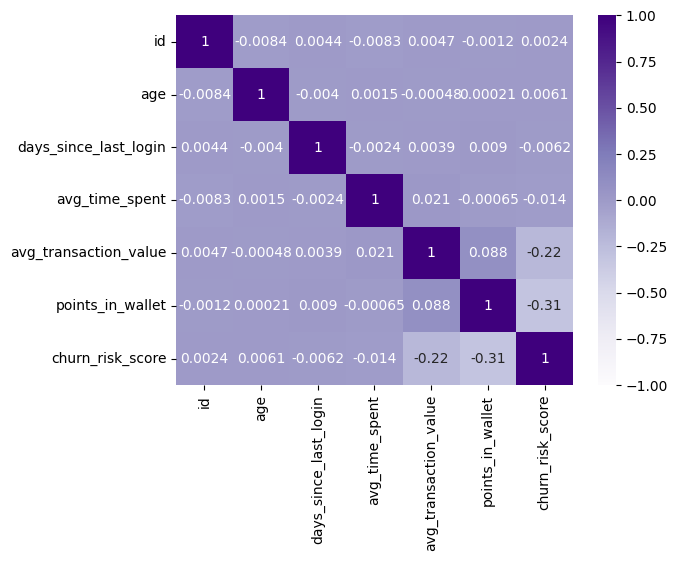

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_value = merged_df.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr_value, vmax=1, vmin=-1,cmap='Purples', annot=True)
plt.show()

1. There isn't high correlation between independent features and customer chrun 
2. Maximum -ve correlation between `point in wallet` and customer chrun is -0.31

## 5.5 Data Distribution <a id='dist'></a>

### 5.5.1 Data Distribution of Features <a id='dist_feature'></a>

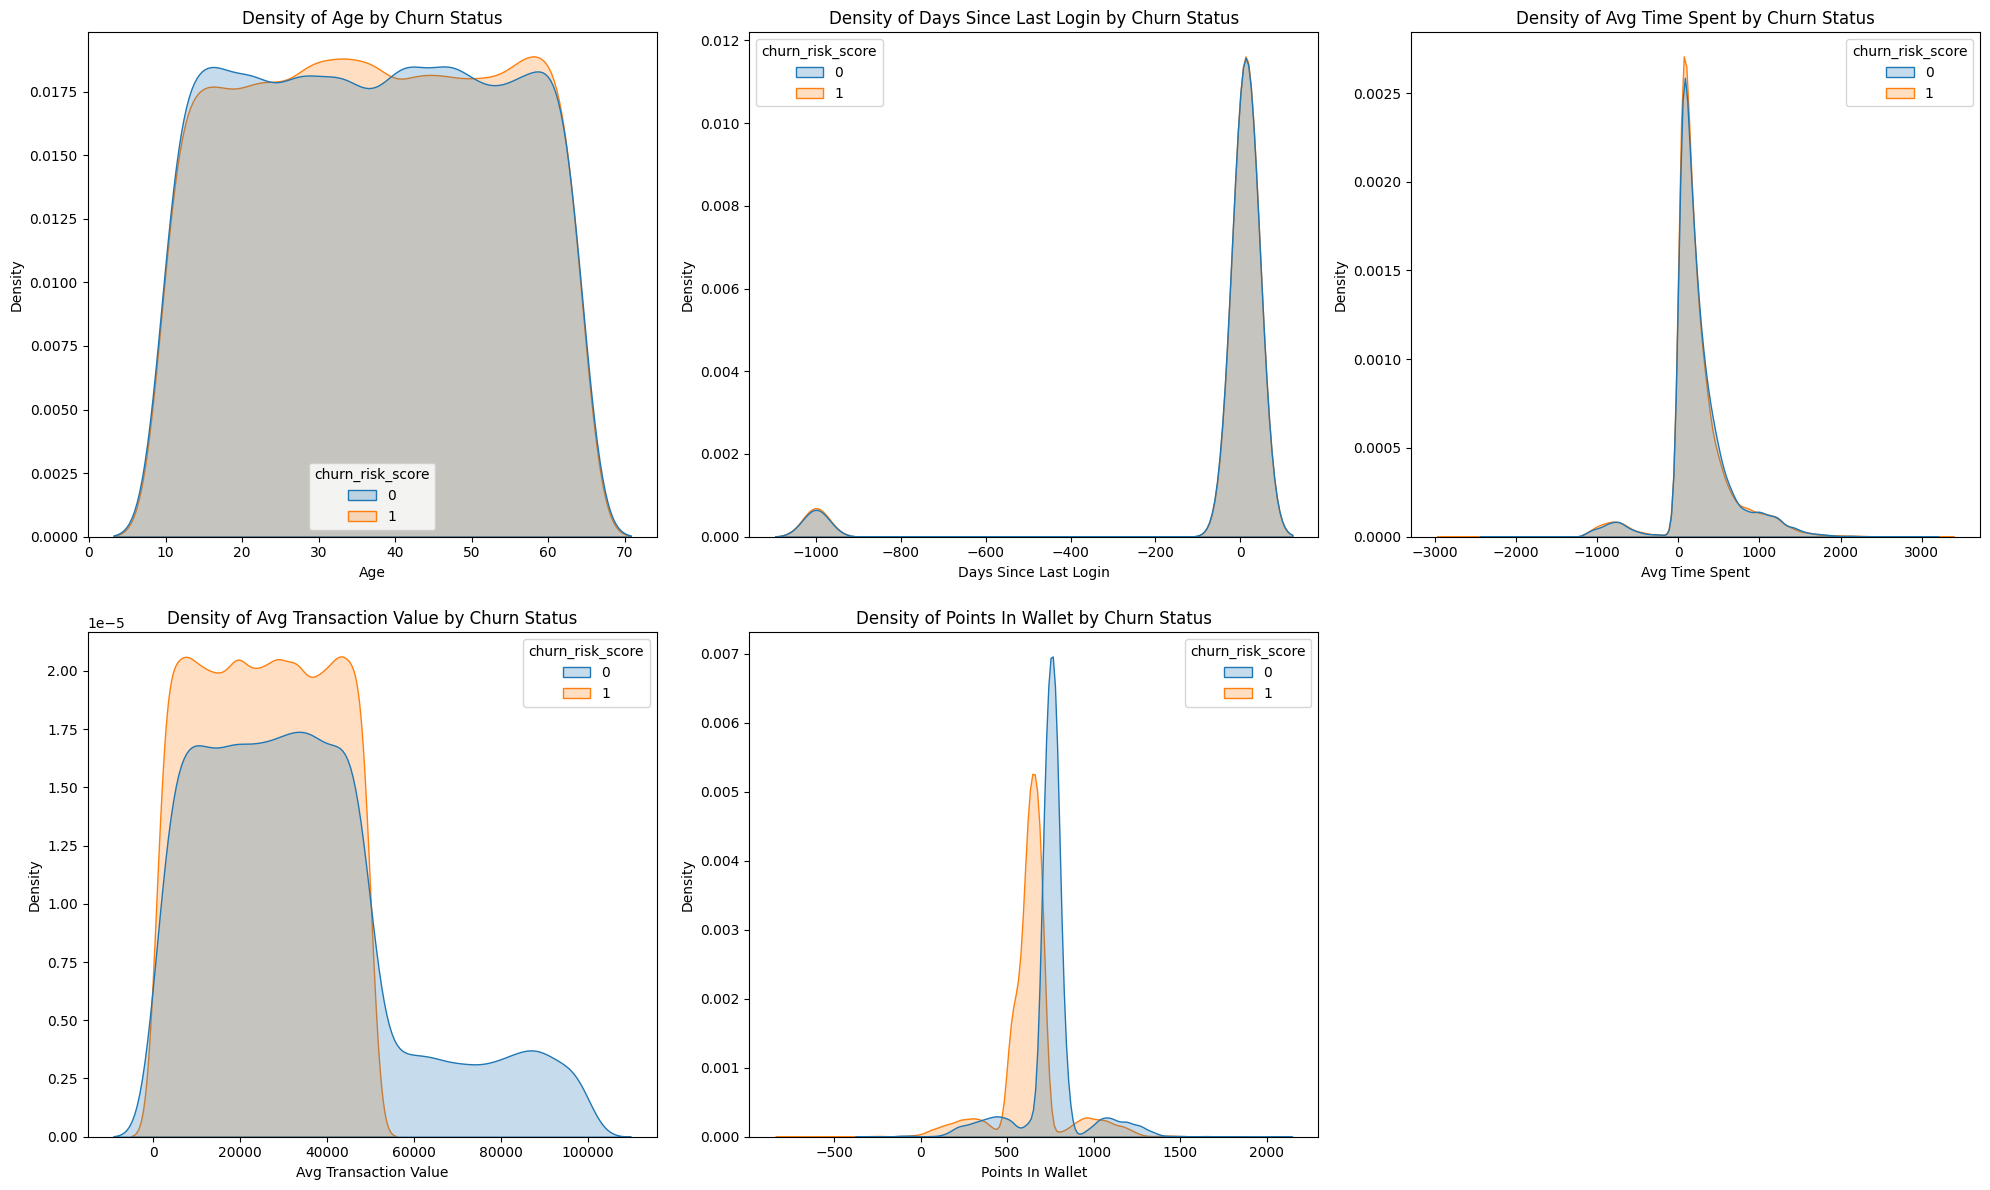

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assumes 'merged_df2' is your preprocessed DataFrame
# containing both numerical features and the 'churn_risk_score' column.

numerical_features = [
    "age",
    "days_since_last_login",
    "avg_time_spent",
    "avg_transaction_value",
    "points_in_wallet"
]

# --- Overlaid Kernel Density Estimation (KDE) Plot ---
# --- Create a 2x3 grid of subplots ---
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 12))

# Flatten the 2D array of axes for easy iteration
axes = axes.flatten()

# Loop through each feature and its corresponding subplot axis
for i, feature in enumerate(numerical_features):
    ax = axes[i] # Select the current subplot
    
    # Generate the KDE Plot on the specific subplot 'ax'
    sns.kdeplot(data=merged_df, x=feature, hue='churn_risk_score', 
                fill=True, common_norm=False, ax=ax)

    # Set titles and labels dynamically for the current subplot
    ax.set_title(f'Density of {feature.replace("_", " ").title()} by Churn Status')
    ax.set_xlabel(f'{feature.replace("_", " ").title()}')
    ax.set_ylabel('Density')

# Hide the last unused subplot
# This will turn off the axis for the 6th plot since we only have 5 features
for i in range(len(numerical_features), len(axes)):
    axes[i].axis('off')

# Adjust the layout to prevent titles and labels from overlapping
plt.tight_layout()

# Display the single figure containing all the plots
plt.show()

In [ ]:
# 1. Define the list of all categorical features to analyze against the churn score
categorical_features = [
    'gender', 
    'region_category', 
    'membership_category',
    'joined_through_referral',
    'preferred_offer_types',
    'medium_of_operation',
    'internet_option',
    'used_special_discount',
    'offer_application_preference',
    'past_complaint'
]

# Loop through each feature and create a cross-tabulation with the churn_risk_score
print("--- Bivariate Analysis of Categorical Features vs. Churn ---")
for column in categorical_features:
    print(f"\n--- Distribution of '{column}' by Churn Status ---")
    # pandas.crosstab creates a frequency table showing the relationship
    # between the feature (index) and the churn score (columns).
    crosstab_result = pd.crosstab(index=merged_df[column], columns=merged_df['churn_risk_score'])
    
    # Sort the table by the churn column (1) in descending order
    sorted_crosstab = crosstab_result.sort_values(by=1, ascending=False)
    print(sorted_crosstab)


#1. As we can see both genders, `Male` and `Female` are equally distributed and there is some noise which will be handled in [Section 6.1.2](#NS_Missing_Values)
#2. Most of the customers are from town region while least number of customer belongs to village whcih is ~4600. 
#3. No & Basic category are leading one in `membership_category` while premium & platinum are least subscribed which is around ~4300+ 
#4. Around 15K customers have joined through referral program
#5. Most of the customers either use Desktop or Smartphone to access website
#6. Most of the customers has given negative feedback about the service such as `poor website`, `poor customer service` etc.

--- Bivariate Analysis of Categorical Features vs. Churn ---

--- Distribution of 'gender' by Churn Status ---
churn_risk_score     0      1
gender                       
F                 8441  10049
M                 8508   9934
Unknown             30     29

--- Distribution of 'region_category' by Churn Status ---
churn_risk_score     0     1
region_category             
Town              6469  7658
City              5768  6969
Village           2293  2406

--- Distribution of 'membership_category' by Churn Status ---
churn_risk_score        0     1
membership_category            
Basic Membership      251  7473
No Membership         226  7466
Silver Membership    3427  2560
Gold Membership      4282  2513
Platinum Membership  4338     0
Premium Membership   4455     0

--- Distribution of 'joined_through_referral' by Churn Status ---
churn_risk_score            0     1
joined_through_referral            
Yes                      6952  8763
No                       7575  8263
?    

### 5.5.2 Data Distribution of Target <a id='dist_target'></a>

In [ ]:
print(merged_df['churn_risk_score'].value_counts(), "\n")

print(merged_df['churn_risk_score'].value_counts(normalize=True))
# Target feature **churn_risk_score**'s classes `Custimer will Exit (1)` and `Customer wont exit (0)` are kind of equally distributed 

churn_risk_score
1    20012
0    16979
Name: count, dtype: int64 

churn_risk_score
1    0.540996
0    0.459004
Name: proportion, dtype: float64


# 6.0 Data Preprocessing <a id='data_pre'></a>

## 6.1 Missing values <a id='Missing_Values'></a>

### 6.1.1 Standard Missing Values  <a id='S_Missing_Values'></a>

In [ ]:
missing_values = pd.DataFrame({
    'missing_values':merged_df.isnull().sum(),
    'percentage': merged_df.isnull().sum()*100/merged_df.shape[0]
})

missing_values.sort_values(by='missing_values', ascending=False)

,missing_values,percentage
region_category,5428,14.673840
points_in_wallet,3443,9.307669
preferred_offer_types,288,0.778568
id,0,0.000000
days_since_last_login,0,0.000000
churn_risk_score,0,0.000000
complaint_status,0,0.000000
past_complaint,0,0.000000
offer_application_preference,0,0.000000
used_special_discount,0,0.000000


Above datafram shows that missing values which are `NaN` values but there are some non-standard missing values which needs to be treated before further processing.

### 6.1.2 Non-Standard Missing Values <a id='NS_Missing_Values'></a>

<table align="left">
    <tr>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>
The non-standard missing values are replaced with NaN                    </b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [ ]:
merged_df.joined_through_referral.value_counts()

joined_through_referral
No     15838
Yes    15715
?       5438
Name: count, dtype: int64

<table align="left">
    <tr>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>
                      The feature joined_through_referral has unindentified '?' values which are replaced with Nan.
                    </b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [ ]:
merged_df['joined_through_referral'] = merged_df['joined_through_referral'].replace('?',np.nan)

In [ ]:
merged_df.gender.value_counts()

gender
F          18490
M          18442
Unknown       59
Name: count, dtype: int64

<table align="left">
    <tr>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>
                        The feature gender has unindentified 'Unknown' values which are replaced with Nan. 
                    </b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [ ]:
merged_df['gender'] = merged_df['gender'].replace('Unknown',np.nan)

In [ ]:
merged_df.referral_id.unique()

array(['xxxxxxxx', 'CID21329', 'CID12313', ..., 'CID60808', 'CID10431',
       'CID45477'], dtype=object)

<table align="left">
    <tr>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>
                        The feature referral_id has unindentified 'xxxxxxxx' values which are replaced with Nan.
                    </b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [ ]:
merged_df['referral_id'] = merged_df['referral_id'].replace('xxxxxxxx',np.nan)  

In [ ]:
merged_df.medium_of_operation.value_counts()

medium_of_operation
Desktop       13912
Smartphone    13876
?              5393
Both           3810
Name: count, dtype: int64

<table align="left">
    <tr>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>    
The feature medium_of_operation has unindentified '?' values which are replaced with Nan. 
                    </b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [ ]:
merged_df['medium_of_operation'] = merged_df['medium_of_operation'].replace('?',np.nan)  

In [ ]:
merged_df.days_since_last_login.value_counts()

days_since_last_login
 12     2380
 13     2373
 14     2307
 15     2277
 11     2262
 10     2091
 16     2068
-999    1999
 9      1863
 17     1747
 8      1571
 18     1444
 7      1442
 19     1308
 6      1257
 5      1234
 20     1184
 21     1015
 4       998
 22      895
 3       852
 23      727
 2       613
 24      471
 1       328
 25      203
 26       82
Name: count, dtype: int64

<table align="left">
    <tr>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>
                        The feature days_since_last_login has unindentified '-999' values which are replaced with Nan. 
                   </b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [ ]:
merged_df['days_since_last_login'] = merged_df['days_since_last_login'].replace(-999,np.nan)  

In [ ]:
len(merged_df[merged_df.avg_time_spent < 0]['avg_time_spent'])

1719

In [ ]:
merged_df['avg_time_spent'] = merged_df['avg_time_spent'].apply(lambda x:x if x>=0 else np.nan)

<table align="left">
    <tr>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>
                        The feature avg_time_spent has negative values which are replaced with Nan
                    </b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [ ]:
len(merged_df[merged_df.points_in_wallet < 0]['points_in_wallet'])

136

<table align="left">
    <tr>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>
                        The feature points_in_wallet has negative values which are replaced with Nan
                    </b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [ ]:
merged_df['points_in_wallet'] = merged_df['points_in_wallet'].apply(lambda x:x if x>=0 else np.nan)

<table align="left">
    <tr>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>
                        The feature avg_frequency_login_days has negative values as well as unidentified 'Error' values which are replaced with Nan
                    </b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [ ]:
merged_df['avg_frequency_login_days'] = merged_df['avg_frequency_login_days'].apply(lambda x:x if x!='Error' else -1)
merged_df['avg_frequency_login_days'] = merged_df['avg_frequency_login_days'].astype('float')
merged_df['avg_frequency_login_days'] = merged_df['avg_frequency_login_days'].apply(lambda x:x if x>=0 else np.nan)

In [ ]:
missing_values = pd.DataFrame({
    'missing_values': merged_df.isnull().sum(),
    'percentage': merged_df.isnull().sum()*100/merged_df.shape[0]
})

missing_values.sort_values(by='missing_values', ascending=False)

,missing_values,percentage
referral_id,17845,48.241464
joined_through_referral,5438,14.700873
region_category,5428,14.673840
medium_of_operation,5393,14.579222
avg_frequency_login_days,4204,11.364927
points_in_wallet,3579,9.675326
days_since_last_login,1999,5.404017
avg_time_spent,1719,4.647076
preferred_offer_types,288,0.778568
gender,59,0.159498


<table align="left">
    <tr>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>
                        There are 10 features that has missing values. referral_id has the most missing values around 48%. 
                    </b>
                </font>
            </div>
        </td>
    </tr>
</table>

### 6.1.3 Missing values imputation <a id='impute'></a>

**Missing values treatment for categorical variable**

In [ ]:
Missing_cat = merged_df[['gender','preferred_offer_types',
                         'region_category','joined_through_referral',
                         'medium_of_operation']]
for i,col in enumerate(Missing_cat):
    merged_df[col].fillna(merged_df[col].mode()[0], inplace=True)

**Missing values treatment for numerical variable**

In [ ]:
Missing_num = merged_df[['points_in_wallet','avg_time_spent',
                'days_since_last_login','avg_frequency_login_days']]

In [ ]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=3)
imputed_value=imputer.fit_transform(Missing_num)

1. For imputing missing values for categorical features we have used mode value
2. For imputing missing values for numerical featurers we have used `KNNimputer` after experimenting with other imputation methods such as `mean` & `median` and we got better results with KNNimputer.

In [ ]:
d1 = pd.DataFrame({
    'avg_frequency_login_days':imputed_value.T[0],
    'points_in_wallet':imputed_value.T[1],
    'days_since_last_login':imputed_value.T[2],
    'avg_time_spent':imputed_value.T[3]

})

# not dropping id here because we will need it as the unique identifier to merge the textual data with the structured data
merged_df.drop(['avg_frequency_login_days','points_in_wallet','days_since_last_login','avg_time_spent'], axis=1, inplace=True)

merged_df2 = pd.concat([merged_df, d1], axis=1)

## 6.2 Handle Duplicate Data

In [ ]:
merged_df2[merged_df2.duplicated()]

,id,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,preferred_offer_types,...,used_special_discount,offer_application_preference,past_complaint,complaint_status,churn_risk_score,feedback,avg_frequency_login_days,points_in_wallet,days_since_last_login,avg_time_spent


<table align="left">
    <tr>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>
There is no duplication in dataset.                    </b>
                </font>
            </div>
        </td>
    </tr>
</table>



## 6.3 Feature Engineering  <a id='feature_eng'></a>

In [ ]:
merged_df2.joining_date

0         17/8/2017
1         28/8/2017
2        11/11/2016
3        29/10/2016
4         12/9/2017
            ...    
36986      7/9/2015
36987     21/9/2017
36988     27/6/2016
36989     11/9/2016
36990     15/6/2017
Name: joining_date, Length: 36991, dtype: object

In [ ]:
# Convert joining_date to datetime format
merged_df2['joining_date'] = pd.to_datetime(merged_df2['joining_date'], dayfirst=True, errors='coerce')

# Now extract the year difference
merged_df2['year'] = 2021 - merged_df2['joining_date'].dt.year

In [ ]:
merged_df2.drop(['security_no','joining_date','referral_id',
           'last_visit_time'], axis=1, inplace=True)

1. Created new feature `year` from joining_date 
2. Dropped features such as security_no, referral_id etc. because either they aren't valuable for predicting churn or having major missing values.

## 6.4 Outliers <a id='out'></a>

### 6.4.1 Discovery of Outliers <a id='dis_out'></a>

In [ ]:
df_num = merged_df2.select_dtypes(include=[np.number]) 

In [ ]:
Q1 = df_num.quantile(0.25)
Q3 = df_num.quantile(0.75) 
IQR = Q3 - Q1 

outlier = pd.DataFrame((df_num < (Q1 - 1.5 * IQR)) | (df_num > (Q3 + 1.5 * IQR)))
for i in outlier.columns:
    print(f'Total number of Outliers in column {i} are {len(outlier[outlier[i] == True][i])}')

Total number of Outliers in column id are 0
Total number of Outliers in column age are 0
Total number of Outliers in column avg_transaction_value are 1131
Total number of Outliers in column churn_risk_score are 0
Total number of Outliers in column avg_frequency_login_days are 4421
Total number of Outliers in column points_in_wallet are 2907
Total number of Outliers in column days_since_last_login are 0
Total number of Outliers in column avg_time_spent are 417
Total number of Outliers in column year are 0


### 6.4.2 Visualizing outliers using Boxplots <a id='viz'></a>

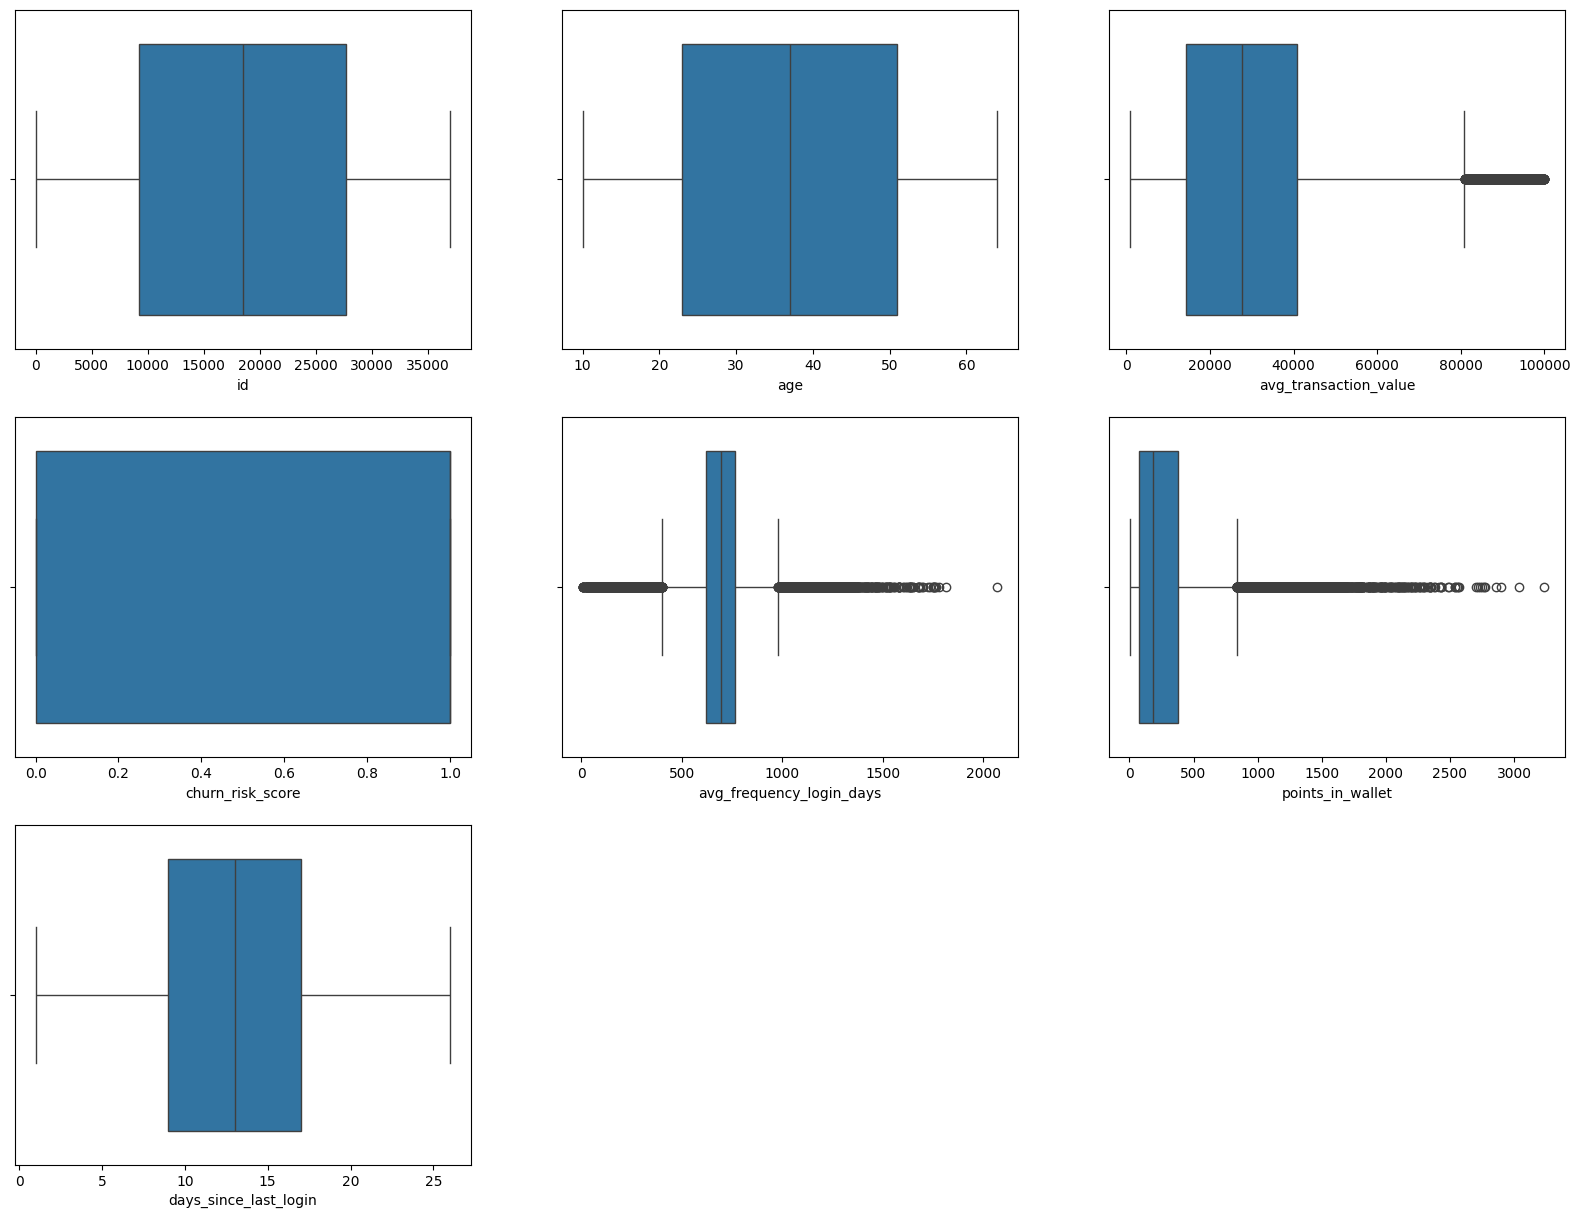

In [ ]:
fig,ax= plt.subplots(nrows=3,ncols=3,figsize=(20, 15)) 
for variable, subplot in zip(df_num.columns,ax.flatten()):
    z = sns.boxplot(x = df_num[variable], orient = "h",whis=1.5 , ax=subplot) 
    z.set_xlabel(variable, fontsize = 10)
    
fig.delaxes(ax[2][1])
fig.delaxes(ax[2][2])
plt.show()

1. Features such as `age`, `day_since_last_login` have no outliers
2. `points in wallet` and `avg frequency login days` are having outliers in large numbers, which will be treated in next section

## 6.4 Categorical Data Encoding  <a id='cat_enc'></a>

In [ ]:
df_cat = merged_df2[['gender','region_category','joined_through_referral','preferred_offer_types',
                     'medium_of_operation','internet_option','used_special_discount',
                     'offer_application_preference','past_complaint']]
df_num = merged_df2.select_dtypes(include=np.number)

In [ ]:
from sklearn.preprocessing import OrdinalEncoder, StandardScaler 

orderencoding_membership_category = OrdinalEncoder(categories = [["No Membership", "Basic Membership", "Silver Membership", "Gold Membership","Platinum Membership","Premium Membership"]])
merged_df2['membership_category'] = orderencoding_membership_category.fit_transform(merged_df2['membership_category'].values.reshape(-1,1))

orderencoding_complaint_status = OrdinalEncoder(categories = [["No Information Available", "Not Applicable", "Unsolved","Solved","Solved in Follow-up"]])
merged_df2['complaint_status'] = orderencoding_complaint_status.fit_transform(merged_df2['complaint_status'].values.reshape(-1,1)) 

df_categorical = pd.get_dummies(df_cat, drop_first=True, dtype=int)

1. For features such as `membership_category` and `complaint_status` we have used **OrdinalEncoder** because there is kind hierarchy in which we can order classes of these features.
2. We have used dummy encoded features such as age, region, medium_of_operation, and internet_option etc.

In [ ]:
merged_df_final = pd.concat([df_categorical, df_num, 
                             merged_df2['membership_category'], 
                             merged_df2['complaint_status'], 
                             merged_df2['feedback']], axis=1)

## 6.6 Feature Scaling  <a id='fea_sca'></a>

In [ ]:
col = merged_df_final[['age','days_since_last_login',
                       'avg_time_spent','avg_transaction_value',
                       'avg_frequency_login_days','points_in_wallet']]

merged_df_final.drop(['age','days_since_last_login','avg_time_spent',
                      'avg_transaction_value','avg_frequency_login_days',
                      'points_in_wallet'], axis=1, inplace=True)

In [ ]:
standard_scale = StandardScaler() 
col1 = standard_scale.fit_transform(col) 
merged_df_scaled = pd.DataFrame(col1, columns=col.columns)

In [ ]:
merged_df_scaled.head()

,age,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet
0,-1.204873,0.775608,0.063415,1.220580,0.510019,0.016363
1,-0.322562,0.592715,-0.804787,-0.845160,-0.880395,0.033783
2,0.433705,0.226928,0.683559,-0.424028,-1.045753,0.673908
3,-0.007450,-0.321751,-1.300902,-0.207380,-0.675049,-0.738290
4,-0.385584,1.324288,-0.060614,-0.246256,-0.146974,-0.555667


In [ ]:
merged_data_final = pd.concat([merged_df_final, 
                            merged_df_scaled], axis=1 )

In [ ]:
merged_data_final.head()

,gender_M,region_category_Town,region_category_Village,joined_through_referral_Yes,preferred_offer_types_Gift Vouchers/Coupons,preferred_offer_types_Without Offers,medium_of_operation_Desktop,medium_of_operation_Smartphone,internet_option_Mobile_Data,internet_option_Wi-Fi,...,year,membership_category,complaint_status,feedback,age,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet
0,0,0,1,0,1,0,1,0,0,1,...,4,4.0,1.0,I’ve always appreciated the quality of custome...,-1.204873,0.775608,0.063415,1.220580,0.510019,0.016363
1,0,0,0,0,1,0,1,0,1,0,...,4,5.0,3.0,I’ve been a regular user of your website for a...,-0.322562,0.592715,-0.804787,-0.845160,-0.880395,0.033783
2,0,1,0,1,1,0,1,0,0,1,...,5,0.0,4.0,I've been frustrated with the website's perfor...,0.433705,0.226928,0.683559,-0.424028,-1.045753,0.673908
3,1,0,0,1,1,0,1,0,1,0,...,5,0.0,2.0,I’ve been a regular user of your website for a...,-0.007450,-0.321751,-1.300902,-0.207380,-0.675049,-0.738290
4,0,0,0,0,0,0,0,1,1,0,...,4,0.0,3.0,No reason specified,-0.385584,1.324288,-0.060614,-0.246256,-0.146974,-0.555667


In [ ]:
# output the cleaned data
merged_data_final.to_csv("../../data/processed/cleaned_data.csv.gz", compression="gzip", index=False)

# 7.0 Preparation for Modeling <a id='eval'></a> 

In [ ]:
X = merged_data_final.drop(['churn_risk_score'] ,axis = 1)
y = merged_data_final['churn_risk_score']

## 7.1 Train test validation split with stratified sampling

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
                    X, y, train_size=0.6, 
                    stratify= y,
                    random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(
                    X_temp, y_temp, train_size=0.5,
                    stratify=y_temp,
                    random_state=42)


In [ ]:
# Export train and test dataset to `data` folder
pd.concat([X_train, y_train], axis=1).to_csv("../../data/input/train.csv.gz", index=False)
pd.concat([X_valid, y_valid], axis=1).to_csv("../../data/input/valid.csv.gz", index=False)
pd.concat([X_test, y_test], axis=1).to_csv("../../data/input/test.csv.gz", index=False)

## 7.2 Text Representation with LLM embedding

### 7.2.1 Generate LLM embedding for synthentic 'feedback' column

In [ ]:
import os
import pandas as pd 
from utils.prepare_llm_embedding import generate_embeddings_from_series 

EMBEDDING_TRAIN = "../../data/processed/llm_embedding_train.csv.gz"
if os.path.exists(EMBEDDING_TRAIN):
    pass
else:
    processed_text_series = pd.Series(X_train["feedback"].to_list(),
                                    index=X_train['id'].to_list()) 
    llm_embedding_train = generate_embeddings_from_series(processed_text_series,
                            additional_data={"churn_risk_score": y_train.to_list()},
                            output_csv_path="../../data/processed/llm_embedding_train.csv.gz",
                            max_workers=20)
    print(llm_embedding_train)
    

In [ ]:
import os
import pandas as pd 
from utils.prepare_llm_embedding import generate_embeddings_from_series 

EMBEDDING_VALID = "../../data/processed/llm_embedding_valid.csv.gz"
if os.path.exists(EMBEDDING_VALID):
    pass
else:
    processed_text_series = pd.Series(X_valid["feedback"].to_list(),
                                    index=X_valid['id'].to_list()) 
    llm_embedding_valid = generate_embeddings_from_series(processed_text_series,
                            additional_data={"churn_risk_score": y_valid.to_list()},
                            output_csv_path="../../data/processed/llm_embedding_valid.csv.gz",
                            max_workers=20)
    print(llm_embedding_valid)

In [ ]:
import os
import pandas as pd 
from utils.prepare_llm_embedding import generate_embeddings_from_series 

EMBEDDING_TEST = "../../data/processed/llm_embedding_test.csv.gz"
if os.path.exists(EMBEDDING_TEST):
    pass
else:
    processed_text_series = pd.Series(X_test["feedback"].to_list(),
                                    index=X_test['id'].to_list()) 
    llm_embedding_test= generate_embeddings_from_series(processed_text_series,
                            additional_data={"churn_risk_score": y_test.to_list()},
                            output_csv_path="../../data/processed/llm_embedding_test.csv.gz",
                            max_workers=20)
    print(llm_embedding_test)

### 7.2.2 Combine LLM embeddings with structured data

In [ ]:
train_text_vectorized = pd.read_csv("../../data/processed/llm_embedding_train.csv.gz", compression="gzip")
valid_text_vectorized = pd.read_csv("../../data/processed/llm_embedding_valid.csv.gz", compression="gzip")
test_text_vectorized = pd.read_csv("../../data/processed/llm_embedding_test.csv.gz", compression="gzip")

In [ ]:
import ast

# Create train df which combines all structured data and textual data
train_df = pd.merge(X_train, train_text_vectorized[['id', 'embedding_json', 'churn_risk_score']], on='id', how='outer')
train_df['embedding_json'] = train_df['embedding_json'].apply(ast.literal_eval)

# create dataframe with columns with 'unstructured data'
X_train_unstructured_llm_embedding = pd.DataFrame(train_df['embedding_json'].tolist())
X_train_unstructured_llm_embedding.columns = [f"text_feature_{i+1}" for i in range(X_train_unstructured_llm_embedding.shape[1])]

# create dataframe with columns with 'structured data'
X_train_structured = train_df.drop(columns=['feedback', 'embedding_json', 'churn_risk_score'])

# Concatenate with both dataframe with structured and unstructured data
X_train_vectorized = pd.concat([X_train_structured, X_train_unstructured_llm_embedding], axis=1).drop(columns=['id'])
X_train_vectorized_with_id = pd.concat([X_train_structured, X_train_unstructured_llm_embedding], axis=1)

# Create target variable
y_train = train_df['churn_risk_score']

In [ ]:
# Create validation df which combines all structured data and textual data
valid_df = pd.merge(X_valid, valid_text_vectorized[['id', 'embedding_json', 'churn_risk_score']], on='id', how='outer')
valid_df['embedding_json'] = valid_df['embedding_json'].apply(ast.literal_eval)

# create dataframe with columns with 'unstructured data'
X_valid_unstructured_llm_embedding = pd.DataFrame(valid_df['embedding_json'].tolist())
X_valid_unstructured_llm_embedding.columns = [f"text_feature_{i+1}" for i in range(X_valid_unstructured_llm_embedding.shape[1])]

# create dataframe with columns with 'structured data'
X_valid_structured = valid_df.drop(columns=['feedback', 'embedding_json', 'churn_risk_score'])

# Concatenate with both dataframe with structured and unstructured data
X_valid_vectorized  = pd.concat([X_valid_structured, X_valid_unstructured_llm_embedding], axis=1).drop(columns=['id'])
X_valid_vectorized_with_id  = pd.concat([X_valid_structured, X_valid_unstructured_llm_embedding], axis=1)

# Create target variable
y_valid = valid_df['churn_risk_score']

In [ ]:
# Create test df which combines all structured data and textual data
test_df = pd.merge(X_test, test_text_vectorized[['id', 'embedding_json', 'churn_risk_score']], on='id', how='outer')
test_df['embedding_json'] = test_df['embedding_json'].apply(ast.literal_eval)

# create dataframe with columns with 'unstructured data'
X_test_unstructured_llm_embedding = pd.DataFrame(test_df['embedding_json'].tolist())
X_test_unstructured_llm_embedding.columns = [f"text_feature_{i+1}" for i in range(X_test_unstructured_llm_embedding.shape[1])]

# create dataframe with columns with 'structured data'
X_test_structured = test_df.drop(columns=['feedback', 'embedding_json', 'churn_risk_score'])

## Concatenate with original dataframe (drop embedding_json)
X_test_vectorized = pd.concat([X_test_structured, X_test_unstructured_llm_embedding], axis=1).drop(columns=['id'])
X_test_vectorized_with_id = pd.concat([X_test_structured, X_test_unstructured_llm_embedding], axis=1)

# Create target variable
y_test = test_df['churn_risk_score']

# 8.0 Modeling

## 8.1 Modeling on structured data

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (f1_score, accuracy_score, precision_score, 
                             recall_score, classification_report, confusion_matrix)

# Initialize the Logistic Regression model
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_structured, y_train)

# Predictions on training and valid sets
y_train_pred_lr = lr_model.predict(X_train_structured)
y_valid_pred_lr = lr_model.predict(X_valid_structured)
y_test_pred_lr = lr_model.predict(X_test_structured)

# Accuracy scores
train_accuracy = accuracy_score(y_train, y_train_pred_lr)
valid_accuracy = accuracy_score(y_valid, y_valid_pred_lr)
test_accuracy = accuracy_score(y_test, y_test_pred_lr)

# F1 scores
train_f1_score = f1_score(y_train, y_train_pred_lr, average='weighted')
valid_f1_score = f1_score(y_valid, y_valid_pred_lr, average='weighted')
test_f1_score = f1_score(y_test, y_test_pred_lr, average='weighted')

# Precision scores
train_precision = precision_score(y_train, y_train_pred_lr, average='weighted')
valid_precision = precision_score(y_valid, y_valid_pred_lr, average='weighted')
test_precision = precision_score(y_test, y_test_pred_lr, average='weighted')

# Recall scores
train_recall = recall_score(y_train, y_train_pred_lr, average='weighted')
valid_recall = recall_score(y_valid, y_valid_pred_lr, average='weighted')
test_recall = recall_score(y_test, y_test_pred_lr, average='weighted')

# Output
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy:  {valid_accuracy:.4f}")
print(f"Test Accuracy:  {test_accuracy:.4f}\n")

print(f"Train F1-score: {train_f1_score:.4f}")
print(f"Validation F1-score:  {valid_f1_score:.4f}")
print(f"Test F1-score:  {test_f1_score:.4f}\n")

print(f"Train Precision: {train_precision:.4f}")
print(f"Validation Precision:  {valid_precision:.4f}")
print(f"Test F1-score:  {test_precision:.4f}\n")

print(f"Train Recall: {train_recall:.4f}")
print(f"Validation Recall:  {valid_recall:.4f}")
print(f"Test Recall:  {test_recall:.4f}\n")

print("Classification Report (Test):")
print(classification_report(y_test, y_test_pred_lr))

print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred_lr))

Train Accuracy: 0.8444
Validation Accuracy:  0.8494
Test Accuracy:  0.8420

Train F1-score: 0.8442
Validation F1-score:  0.8492
Test F1-score:  0.8419

Train Precision: 0.8443
Validation Precision:  0.8493
Test F1-score:  0.8419

Train Recall: 0.8444
Validation Recall:  0.8494
Test Recall:  0.8420

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.83      0.82      0.83      3396
           1       0.85      0.86      0.86      4003

    accuracy                           0.84      7399
   macro avg       0.84      0.84      0.84      7399
weighted avg       0.84      0.84      0.84      7399

Confusion Matrix (Test):
[[2779  617]
 [ 552 3451]]


(ii) Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (f1_score, accuracy_score, precision_score, 
                             recall_score, classification_report, confusion_matrix)

# Initialize the Decision Tree
dt_model = DecisionTreeClassifier(max_depth=100, 
                                  min_samples_split=10, 
                                  criterion='entropy', 
                                  min_samples_leaf=100,
                                  random_state=42)
dt_model.fit(X_train_structured, y_train)

# Predictions on training and test sets
y_train_pred_dt = dt_model.predict(X_train_structured)
y_valid_pred_dt = dt_model.predict(X_valid_structured)
y_test_pred_dt = dt_model.predict(X_test_structured)

# Accuracy scores
train_accuracy = accuracy_score(y_train, y_train_pred_dt)
valid_accuracy = accuracy_score(y_valid, y_valid_pred_dt)
test_accuracy = accuracy_score(y_test, y_test_pred_dt)

# F1 scores
train_f1_score = f1_score(y_train, y_train_pred_dt, average='weighted')
valid_f1_score = f1_score(y_valid, y_valid_pred_dt, average='weighted')
test_f1_score = f1_score(y_test, y_test_pred_dt, average='weighted')

# Precision scores
train_precision = precision_score(y_train, y_train_pred_dt, average='weighted')
valid_precision = precision_score(y_valid, y_valid_pred_dt, average='weighted')
test_precision = precision_score(y_test, y_test_pred_dt, average='weighted')

# Recall scores
train_recall = recall_score(y_train, y_train_pred_dt, average='weighted')
valid_recall = recall_score(y_valid, y_valid_pred_dt, average='weighted')
test_recall = recall_score(y_test, y_test_pred_dt, average='weighted')

# Output
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Valid Accuracy:  {valid_accuracy:.4f}")
print(f"Test Accuracy:  {test_accuracy:.4f}\n")

print(f"Train F1-score: {train_f1_score:.4f}")
print(f"Valid F1-score:  {valid_f1_score:.4f}")
print(f"Test F1-score:  {test_f1_score:.4f}\n")

print(f"Train Precision: {train_precision:.4f}")
print(f"Valid Precision:  {valid_precision:.4f}")
print(f"Valid Precision:  {valid_precision:.4f}\n")

print(f"Train Recall: {train_recall:.4f}")
print(f"Valid Recall:  {valid_recall:.4f}")
print(f"Test Recall:  {test_recall:.4f}\n")

print("Classification Report (Test):")
print(classification_report(y_test, y_test_pred_dt))

print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred_dt))

Train Accuracy: 0.9333
Valid Accuracy:  0.9305
Test Accuracy:  0.9315

Train F1-score: 0.9332
Valid F1-score:  0.9304
Test F1-score:  0.9314

Train Precision: 0.9334
Valid Precision:  0.9308
Valid Precision:  0.9308

Train Recall: 0.9333
Valid Recall:  0.9305
Test Recall:  0.9315

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.94      0.91      0.92      3396
           1       0.93      0.95      0.94      4003

    accuracy                           0.93      7399
   macro avg       0.93      0.93      0.93      7399
weighted avg       0.93      0.93      0.93      7399

Confusion Matrix (Test):
[[3099  297]
 [ 210 3793]]


(iii) Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (f1_score, accuracy_score, precision_score, 
                             recall_score, classification_report, confusion_matrix)

# Train the model
rf_model = RandomForestClassifier(max_depth=10,
                            bootstrap=False,
                            random_state=42,
                            n_jobs=-1
                            )
rf_model.fit(X_train_structured, y_train)

# Predictions on training and test sets
y_train_pred_rf = rf_model.predict(X_train_structured)
y_valid_pred_rf = rf_model.predict(X_valid_structured)
y_test_pred_rf = rf_model.predict(X_test_structured)

# Accuracy scores
train_accuracy = accuracy_score(y_train, y_train_pred_rf)
valid_accuracy = accuracy_score(y_valid, y_valid_pred_rf)
test_accuracy = accuracy_score(y_test, y_test_pred_rf)

# F1 scores
train_f1_score = f1_score(y_train, y_train_pred_rf, average='weighted')
valid_f1_score = f1_score(y_valid, y_valid_pred_rf, average='weighted')
test_f1_score = f1_score(y_test, y_test_pred_rf, average='weighted')

# Precision scores
train_precision = precision_score(y_train, y_train_pred_rf, average='weighted')
valid_precision = precision_score(y_valid, y_valid_pred_rf, average='weighted')
test_precision = precision_score(y_test, y_test_pred_rf, average='weighted')

# Recall scores
train_recall = recall_score(y_train, y_train_pred_rf, average='weighted')
valid_recall = recall_score(y_valid, y_valid_pred_rf, average='weighted')
test_recall = recall_score(y_test, y_test_pred_rf, average='weighted')

# Output
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Valid Accuracy:  {valid_accuracy:.4f}")
print(f"Test Accuracy:  {test_accuracy:.4f}\n")

print(f"Train F1-score: {train_f1_score:.4f}")
print(f"Valid F1-score:  {valid_f1_score:.4f}")
print(f"Test F1-score:  {test_f1_score:.4f}\n")

print(f"Train Precision: {train_precision:.4f}")
print(f"Valid Precision:  {valid_precision:.4f}")
print(f"Test Precision:  {test_precision:.4f}\n")

print(f"Train Recall: {train_recall:.4f}")
print(f"Valid Recall:  {valid_recall:.4f}")
print(f"Test Recall:  {test_recall:.4f}\n")

print("Classification Report (Test):")
print(classification_report(y_test, y_test_pred_rf))

print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred_rf))

Train Accuracy: 0.9313
Valid Accuracy:  0.9290
Test Accuracy:  0.9308

Train F1-score: 0.9314
Valid F1-score:  0.9290
Test F1-score:  0.9308

Train Precision: 0.9314
Valid Precision:  0.9290
Test Precision:  0.9309

Train Recall: 0.9313
Valid Recall:  0.9290
Test Recall:  0.9308

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.92      0.93      0.92      3396
           1       0.94      0.93      0.94      4003

    accuracy                           0.93      7399
   macro avg       0.93      0.93      0.93      7399
weighted avg       0.93      0.93      0.93      7399

Confusion Matrix (Test):
[[3156  240]
 [ 272 3731]]


(iv) XGBoost

In [ ]:
import xgboost as xgb
from sklearn.metrics import (f1_score, accuracy_score, precision_score, 
                            recall_score, classification_report, confusion_matrix)

# Train the model
xgb_model = xgb.XGBClassifier(max_depth=10,
                            random_state=42,
                            # Introduce randomness to make training faster and reduce overfitting
                            subsample=0.8, ## Uses 80% of the data for each tree.
                            colsample_bytree=0.8, ## Uses 80% of the features for each tree.
                            # the parameters below make the model trained faster by enabling parallelism
                            n_jobs = -1)
xgb_model.fit(X_train_structured, y_train)

# Predictions on training and test sets
y_train_pred_xgb = xgb_model.predict(X_train_structured)
y_valid_pred_xgb = xgb_model.predict(X_valid_structured)
y_test_pred_xgb = xgb_model.predict(X_test_structured)

# Accuracy scores
train_accuracy = accuracy_score(y_train, y_train_pred_xgb)
valid_accuracy = accuracy_score(y_valid, y_valid_pred_xgb)
test_accuracy = accuracy_score(y_test, y_test_pred_xgb)

# F1 scores
train_f1_score = f1_score(y_train, y_train_pred_xgb, average='weighted')
valid_f1_score = f1_score(y_valid, y_valid_pred_xgb, average='weighted')
test_f1_score = f1_score(y_test, y_test_pred_xgb, average='weighted')

# Precision scores
train_precision = precision_score(y_train, y_train_pred_xgb, average='weighted')
valid_precision = precision_score(y_valid, y_valid_pred_xgb, average='weighted')
test_precision = precision_score(y_test, y_test_pred_xgb, average='weighted')

# Recall scores
train_recall = recall_score(y_train, y_train_pred_xgb, average='weighted')
valid_recall = recall_score(y_valid, y_valid_pred_xgb, average='weighted')
test_recall = recall_score(y_test, y_test_pred_xgb, average='weighted')

# Output
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Valid Accuracy:  {valid_accuracy:.4f}")
print(f"Test Accuracy:  {test_accuracy:.4f}\n")

print(f"Train F1-score: {train_f1_score:.4f}")
print(f"Valid F1-score:  {valid_f1_score:.4f}")
print(f"Test F1-score:  {test_f1_score:.4f}\n")

print(f"Train Precision: {train_precision:.4f}")
print(f"Valid Precision:  {valid_precision:.4f}")
print(f"Test Precision:  {test_precision:.4f}\n")

print(f"Train Recall: {train_recall:.4f}")
print(f"Valid Recall:  {valid_recall:.4f}")
print(f"Test Recall:  {test_recall:.4f}\n")

print("Classification Report (Test):")
print(classification_report(y_test, y_test_pred_xgb))

print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred_xgb))

Train Accuracy: 1.0000
Valid Accuracy:  0.9280
Test Accuracy:  0.9286

Train F1-score: 1.0000
Valid F1-score:  0.9278
Test F1-score:  0.9285

Train Precision: 1.0000
Valid Precision:  0.9284
Test Precision:  0.9289

Train Recall: 1.0000
Valid Recall:  0.9280
Test Recall:  0.9286

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.94      0.90      0.92      3396
           1       0.92      0.95      0.94      4003

    accuracy                           0.93      7399
   macro avg       0.93      0.93      0.93      7399
weighted avg       0.93      0.93      0.93      7399

Confusion Matrix (Test):
[[3072  324]
 [ 204 3799]]


## 8.2 Modeling on unstructured data

(i) Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (f1_score, accuracy_score, precision_score, 
                             recall_score, classification_report, confusion_matrix)

# Initialize the Logistic Regression model
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_unstructured_llm_embedding, y_train)

# Predictions on training and valid sets
y_train_pred_lr = lr_model.predict(X_train_unstructured_llm_embedding)
y_valid_pred_lr = lr_model.predict(X_valid_unstructured_llm_embedding)
y_test_pred_lr = lr_model.predict(X_test_unstructured_llm_embedding)

# Accuracy scores
train_accuracy = accuracy_score(y_train, y_train_pred_lr)
valid_accuracy = accuracy_score(y_valid, y_valid_pred_lr)
test_accuracy = accuracy_score(y_test, y_test_pred_lr)

# F1 scores
train_f1_score = f1_score(y_train, y_train_pred_lr, average='weighted')
valid_f1_score = f1_score(y_valid, y_valid_pred_lr, average='weighted')
test_f1_score = f1_score(y_test, y_test_pred_lr, average='weighted')

# Precision scores
train_precision = precision_score(y_train, y_train_pred_lr, average='weighted')
valid_precision = precision_score(y_valid, y_valid_pred_lr, average='weighted')
test_precision = precision_score(y_test, y_test_pred_lr, average='weighted')

# Recall scores
train_recall = recall_score(y_train, y_train_pred_lr, average='weighted')
valid_recall = recall_score(y_valid, y_valid_pred_lr, average='weighted')
test_recall = recall_score(y_test, y_test_pred_lr, average='weighted')

# Output
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy:  {valid_accuracy:.4f}")
print(f"Test Accuracy:  {test_accuracy:.4f}\n")

print(f"Train F1-score: {train_f1_score:.4f}")
print(f"Validation F1-score:  {valid_f1_score:.4f}")
print(f"Test F1-score:  {test_f1_score:.4f}\n")

print(f"Train Precision: {train_precision:.4f}")
print(f"Validation Precision:  {valid_precision:.4f}")
print(f"Test F1-score:  {test_precision:.4f}\n")

print(f"Train Recall: {train_recall:.4f}")
print(f"Validation Recall:  {valid_recall:.4f}")
print(f"Test Recall:  {test_recall:.4f}\n")

print("Classification Report (Test):")
print(classification_report(y_test, y_test_pred_lr))

print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred_lr))

Train Accuracy: 0.5528
Validation Accuracy:  0.5301
Test Accuracy:  0.5366

Train F1-score: 0.4595
Validation F1-score:  0.4314
Test F1-score:  0.4389

Train Precision: 0.5579
Validation Precision:  0.4932
Test F1-score:  0.5115

Train Recall: 0.5528
Validation Recall:  0.5301
Test Recall:  0.5366

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.47      0.09      0.15      3396
           1       0.54      0.91      0.68      4003

    accuracy                           0.54      7399
   macro avg       0.51      0.50      0.42      7399
weighted avg       0.51      0.54      0.44      7399

Confusion Matrix (Test):
[[ 311 3085]
 [ 344 3659]]


(ii) Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (f1_score, accuracy_score, precision_score, 
                             recall_score, classification_report, confusion_matrix)

# Initialize the Decision Tree
dt_model = DecisionTreeClassifier(max_depth=100, 
                                  min_samples_split=10, 
                                  criterion='entropy', 
                                  min_samples_leaf=100,
                                  random_state=42)
dt_model.fit(X_train_unstructured_llm_embedding, y_train)

# Predictions on training and test sets
y_train_pred_lr = lr_model.predict(X_train_unstructured_llm_embedding)
y_valid_pred_lr = lr_model.predict(X_valid_unstructured_llm_embedding)
y_test_pred_lr = lr_model.predict(X_test_unstructured_llm_embedding)

# Accuracy scores
train_accuracy = accuracy_score(y_train, y_train_pred_dt)
valid_accuracy = accuracy_score(y_valid, y_valid_pred_dt)
test_accuracy = accuracy_score(y_test, y_test_pred_dt)

# F1 scores
train_f1_score = f1_score(y_train, y_train_pred_dt, average='weighted')
valid_f1_score = f1_score(y_valid, y_valid_pred_dt, average='weighted')
test_f1_score = f1_score(y_test, y_test_pred_dt, average='weighted')

# Precision scores
train_precision = precision_score(y_train, y_train_pred_dt, average='weighted')
valid_precision = precision_score(y_valid, y_valid_pred_dt, average='weighted')
test_precision = precision_score(y_test, y_test_pred_dt, average='weighted')

# Recall scores
train_recall = recall_score(y_train, y_train_pred_dt, average='weighted')
valid_recall = recall_score(y_valid, y_valid_pred_dt, average='weighted')
test_recall = recall_score(y_test, y_test_pred_dt, average='weighted')

# Output
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Valid Accuracy:  {valid_accuracy:.4f}")
print(f"Test Accuracy:  {test_accuracy:.4f}\n")

print(f"Train F1-score: {train_f1_score:.4f}")
print(f"Valid F1-score:  {valid_f1_score:.4f}")
print(f"Test F1-score:  {test_f1_score:.4f}\n")

print(f"Train Precision: {train_precision:.4f}")
print(f"Valid Precision:  {valid_precision:.4f}")
print(f"Valid Precision:  {valid_precision:.4f}\n")

print(f"Train Recall: {train_recall:.4f}")
print(f"Valid Recall:  {valid_recall:.4f}")
print(f"Test Recall:  {test_recall:.4f}\n")

print("Classification Report (Test):")
print(classification_report(y_test, y_test_pred_dt))

print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred_dt))

Train Accuracy: 0.9333
Valid Accuracy:  0.9305
Test Accuracy:  0.9315

Train F1-score: 0.9332
Valid F1-score:  0.9304
Test F1-score:  0.9314

Train Precision: 0.9334
Valid Precision:  0.9308
Valid Precision:  0.9308

Train Recall: 0.9333
Valid Recall:  0.9305
Test Recall:  0.9315

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.94      0.91      0.92      3396
           1       0.93      0.95      0.94      4003

    accuracy                           0.93      7399
   macro avg       0.93      0.93      0.93      7399
weighted avg       0.93      0.93      0.93      7399

Confusion Matrix (Test):
[[3099  297]
 [ 210 3793]]


(iii) Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (f1_score, accuracy_score, precision_score, 
                             recall_score, classification_report, confusion_matrix)

# Train the model
rf_model = RandomForestClassifier(max_depth=10,
                            bootstrap=False,
                            random_state=42,
                            n_jobs=-1
                            )
rf_model.fit(X_train_unstructured_llm_embedding, y_train)

# Predictions on training and test sets
y_train_pred_rf = rf_model.predict(X_train_unstructured_llm_embedding)
y_valid_pred_rf = rf_model.predict(X_valid_unstructured_llm_embedding)
y_test_pred_rf = rf_model.predict(X_test_unstructured_llm_embedding)

# Accuracy scores
train_accuracy = accuracy_score(y_train, y_train_pred_rf)
valid_accuracy = accuracy_score(y_valid, y_valid_pred_rf)
test_accuracy = accuracy_score(y_test, y_test_pred_rf)

# F1 scores
train_f1_score = f1_score(y_train, y_train_pred_rf, average='weighted')
valid_f1_score = f1_score(y_valid, y_valid_pred_rf, average='weighted')
test_f1_score = f1_score(y_test, y_test_pred_rf, average='weighted')

# Precision scores
train_precision = precision_score(y_train, y_train_pred_rf, average='weighted')
valid_precision = precision_score(y_valid, y_valid_pred_rf, average='weighted')
test_precision = precision_score(y_test, y_test_pred_rf, average='weighted')

# Recall scores
train_recall = recall_score(y_train, y_train_pred_rf, average='weighted')
valid_recall = recall_score(y_valid, y_valid_pred_rf, average='weighted')
test_recall = recall_score(y_test, y_test_pred_rf, average='weighted')

# Output
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Valid Accuracy:  {valid_accuracy:.4f}")
print(f"Test Accuracy:  {test_accuracy:.4f}\n")

print(f"Train F1-score: {train_f1_score:.4f}")
print(f"Valid F1-score:  {valid_f1_score:.4f}")
print(f"Test F1-score:  {test_f1_score:.4f}\n")

print(f"Train Precision: {train_precision:.4f}")
print(f"Valid Precision:  {valid_precision:.4f}")
print(f"Test Precision:  {test_precision:.4f}\n")

print(f"Train Recall: {train_recall:.4f}")
print(f"Valid Recall:  {valid_recall:.4f}")
print(f"Test Recall:  {test_recall:.4f}\n")

print("Classification Report (Test):")
print(classification_report(y_test, y_test_pred_rf))

print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred_rf))

Train Accuracy: 0.7550
Valid Accuracy:  0.5381
Test Accuracy:  0.5397

Train F1-score: 0.7330
Valid F1-score:  0.4147
Test F1-score:  0.4175

Train Precision: 0.8313
Valid Precision:  0.5090
Test Precision:  0.5167

Train Recall: 0.7550
Valid Recall:  0.5381
Test Recall:  0.5397

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.49      0.05      0.09      3396
           1       0.54      0.95      0.69      4003

    accuracy                           0.54      7399
   macro avg       0.51      0.50      0.39      7399
weighted avg       0.52      0.54      0.42      7399

Confusion Matrix (Test):
[[ 178 3218]
 [ 188 3815]]


(iv) XGBoost

In [ ]:
import xgboost as xgb
from sklearn.metrics import (f1_score, accuracy_score, precision_score, 
                            recall_score, classification_report, confusion_matrix)

# Train the model
xgb_model = xgb.XGBClassifier(max_depth=10,
                            random_state=42,
                            # Introduce randomness to make training faster and reduce overfitting
                            subsample=0.8, ## Uses 80% of the data for each tree.
                            colsample_bytree=0.8, ## Uses 80% of the features for each tree.
                            # the parameters below make the model trained faster by enabling parallelism
                            n_jobs = -1)
xgb_model.fit(X_train_unstructured_llm_embedding, y_train)

# Predictions on training and test sets
y_train_pred_xgb = xgb_model.predict(X_train_unstructured_llm_embedding)
y_valid_pred_xgb = xgb_model.predict(X_valid_unstructured_llm_embedding)
y_test_pred_xgb = xgb_model.predict(X_test_unstructured_llm_embedding)

# Accuracy scores
train_accuracy = accuracy_score(y_train, y_train_pred_xgb)
valid_accuracy = accuracy_score(y_valid, y_valid_pred_xgb)
test_accuracy = accuracy_score(y_test, y_test_pred_xgb)

# F1 scores
train_f1_score = f1_score(y_train, y_train_pred_xgb, average='weighted')
valid_f1_score = f1_score(y_valid, y_valid_pred_xgb, average='weighted')
test_f1_score = f1_score(y_test, y_test_pred_xgb, average='weighted')

# Precision scores
train_precision = precision_score(y_train, y_train_pred_xgb, average='weighted')
valid_precision = precision_score(y_valid, y_valid_pred_xgb, average='weighted')
test_precision = precision_score(y_test, y_test_pred_xgb, average='weighted')

# Recall scores
train_recall = recall_score(y_train, y_train_pred_xgb, average='weighted')
valid_recall = recall_score(y_valid, y_valid_pred_xgb, average='weighted')
test_recall = recall_score(y_test, y_test_pred_xgb, average='weighted')

# Output
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Valid Accuracy:  {valid_accuracy:.4f}")
print(f"Test Accuracy:  {test_accuracy:.4f}\n")

print(f"Train F1-score: {train_f1_score:.4f}")
print(f"Valid F1-score:  {valid_f1_score:.4f}")
print(f"Test F1-score:  {test_f1_score:.4f}\n")

print(f"Train Precision: {train_precision:.4f}")
print(f"Valid Precision:  {valid_precision:.4f}")
print(f"Test Precision:  {test_precision:.4f}\n")

print(f"Train Recall: {train_recall:.4f}")
print(f"Valid Recall:  {valid_recall:.4f}")
print(f"Test Recall:  {test_recall:.4f}\n")

print("Classification Report (Test):")
print(classification_report(y_test, y_test_pred_xgb))

print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred_xgb))

Train Accuracy: 0.9237
Valid Accuracy:  0.5143
Test Accuracy:  0.5167

Train F1-score: 0.9227
Valid F1-score:  0.5017
Test F1-score:  0.5036

Train Precision: 0.9331
Valid Precision:  0.5044
Test Precision:  0.5067

Train Recall: 0.9237
Valid Recall:  0.5143
Test Recall:  0.5167

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.46      0.34      0.39      3396
           1       0.54      0.67      0.60      4003

    accuracy                           0.52      7399
   macro avg       0.50      0.50      0.49      7399
weighted avg       0.51      0.52      0.50      7399

Confusion Matrix (Test):
[[1144 2252]
 [1324 2679]]


## 8.3 Modeling on mixed data (on structured data and textual data)

(i) Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (f1_score, accuracy_score, precision_score, 
                             recall_score, classification_report, confusion_matrix)

# Initialize the Logistic Regression model
lr_model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
lr_model.fit(X_train_vectorized, y_train)

# Predictions on training and valid sets
y_train_pred_lr = lr_model.predict(X_train_vectorized)
y_valid_pred_lr = lr_model.predict(X_valid_vectorized)
y_test_pred_lr = lr_model.predict(X_test_vectorized)

# Accuracy scores
train_accuracy = accuracy_score(y_train, y_train_pred_lr)
valid_accuracy = accuracy_score(y_valid, y_valid_pred_lr)
test_accuracy = accuracy_score(y_test, y_test_pred_lr)

# F1 scores
train_f1_score = f1_score(y_train, y_train_pred_lr, average='weighted')
valid_f1_score = f1_score(y_valid, y_valid_pred_lr, average='weighted')
test_f1_score = f1_score(y_test, y_test_pred_lr, average='weighted')

# Precision scores
train_precision = precision_score(y_train, y_train_pred_lr, average='weighted')
valid_precision = precision_score(y_valid, y_valid_pred_lr, average='weighted')
test_precision = precision_score(y_test, y_test_pred_lr, average='weighted')

# Recall scores
train_recall = recall_score(y_train, y_train_pred_lr, average='weighted')
valid_recall = recall_score(y_valid, y_valid_pred_lr, average='weighted')
test_recall = recall_score(y_test, y_test_pred_lr, average='weighted')


# Output
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy:  {valid_accuracy:.4f}")
print(f"Test Accuracy:  {test_accuracy:.4f}\n")

print(f"Train F1-score: {train_f1_score:.4f}")
print(f"Validation F1-score:  {valid_f1_score:.4f}")
print(f"Test F1-score:  {test_f1_score:.4f}\n")

print(f"Train Precision: {train_precision:.4f}")
print(f"Validation Precision:  {valid_precision:.4f}")
print(f"Test F1-score:  {test_precision:.4f}\n")

print(f"Train Recall: {train_recall:.4f}")
print(f"Validation Recall:  {valid_recall:.4f}")
print(f"Test Recall:  {test_recall:.4f}\n")

print("Classification Report (Test):")
print(classification_report(y_test, y_test_pred_lr))

print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred_lr))

Train Accuracy: 0.8460
Validation Accuracy:  0.8497
Test Accuracy:  0.8440

Train F1-score: 0.8459
Validation F1-score:  0.8495
Test F1-score:  0.8439

Train Precision: 0.8459
Validation Precision:  0.8496
Test F1-score:  0.8439

Train Recall: 0.8460
Validation Recall:  0.8497
Test Recall:  0.8440

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.83      0.82      0.83      3396
           1       0.85      0.86      0.86      4003

    accuracy                           0.84      7399
   macro avg       0.84      0.84      0.84      7399
weighted avg       0.84      0.84      0.84      7399

Confusion Matrix (Test):
[[2795  601]
 [ 553 3450]]


(ii) Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (f1_score, accuracy_score, precision_score, 
                             recall_score, classification_report, confusion_matrix)

# Initialize the Decision Tree
dt_model = DecisionTreeClassifier(max_depth=100, 
                                  min_samples_split=10, 
                                  criterion='entropy', 
                                  min_samples_leaf=100,
                                  random_state=42)

# Train the model
dt_model.fit(X_train_vectorized, y_train)

# Predictions on training and test sets
y_train_pred_dt = dt_model.predict(X_train_vectorized)
y_valid_pred_dt = dt_model.predict(X_valid_vectorized)
y_test_pred_dt = dt_model.predict(X_test_vectorized)

# Accuracy scores
train_accuracy = accuracy_score(y_train, y_train_pred_dt)
valid_accuracy = accuracy_score(y_valid, y_valid_pred_dt)
test_accuracy = accuracy_score(y_test, y_test_pred_dt)

# F1 scores
train_f1_score = f1_score(y_train, y_train_pred_dt, average='weighted')
valid_f1_score = f1_score(y_valid, y_valid_pred_dt, average='weighted')
test_f1_score = f1_score(y_test, y_test_pred_dt, average='weighted')

# Precision scores
train_precision = precision_score(y_train, y_train_pred_dt, average='weighted')
valid_precision = precision_score(y_valid, y_valid_pred_dt, average='weighted')
test_precision = precision_score(y_test, y_test_pred_dt, average='weighted')

# Recall scores
train_recall = recall_score(y_train, y_train_pred_dt, average='weighted')
valid_recall = recall_score(y_valid, y_valid_pred_dt, average='weighted')
test_recall = recall_score(y_test, y_test_pred_dt, average='weighted')

# Output
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Valid Accuracy:  {valid_accuracy:.4f}")
print(f"Test Accuracy:  {test_accuracy:.4f}\n")

print(f"Train F1-score: {train_f1_score:.4f}")
print(f"Valid F1-score:  {valid_f1_score:.4f}")
print(f"Test F1-score:  {test_f1_score:.4f}\n")

print(f"Train Precision: {train_precision:.4f}")
print(f"Valid Precision:  {valid_precision:.4f}")
print(f"Valid Precision:  {valid_precision:.4f}\n")

print(f"Train Recall: {train_recall:.4f}")
print(f"Valid Recall:  {valid_recall:.4f}")
print(f"Test Recall:  {test_recall:.4f}\n")

print("Classification Report (Test):")
print(classification_report(y_test, y_test_pred_dt))

print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred_dt))

Train Accuracy: 0.9353
Valid Accuracy:  0.9263
Test Accuracy:  0.9261

Train F1-score: 0.9352
Valid F1-score:  0.9261
Test F1-score:  0.9259

Train Precision: 0.9356
Valid Precision:  0.9271
Valid Precision:  0.9271

Train Recall: 0.9353
Valid Recall:  0.9263
Test Recall:  0.9261

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.94      0.90      0.92      3396
           1       0.92      0.95      0.93      4003

    accuracy                           0.93      7399
   macro avg       0.93      0.92      0.93      7399
weighted avg       0.93      0.93      0.93      7399

Confusion Matrix (Test):
[[3057  339]
 [ 208 3795]]


(iii) Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (f1_score, accuracy_score, precision_score, 
                             recall_score, classification_report, confusion_matrix)

# Train the model
rf_model = RandomForestClassifier(max_depth=10,
                            bootstrap=False,
                            random_state=42,
                            n_jobs=-1
                            )
rf_model.fit(X_train_vectorized, y_train)

# Predictions on training and test sets
y_train_pred_rf = rf_model.predict(X_train_vectorized)
y_valid_pred_rf = rf_model.predict(X_valid_vectorized)
y_test_pred_rf = rf_model.predict(X_test_vectorized)

# Accuracy scores
train_accuracy = accuracy_score(y_train, y_train_pred_rf)
valid_accuracy = accuracy_score(y_valid, y_valid_pred_rf)
test_accuracy = accuracy_score(y_test, y_test_pred_rf)

# F1 scores
train_f1_score = f1_score(y_train, y_train_pred_rf, average='weighted')
valid_f1_score = f1_score(y_valid, y_valid_pred_rf, average='weighted')
test_f1_score = f1_score(y_test, y_test_pred_rf, average='weighted')

# Precision scores
train_precision = precision_score(y_train, y_train_pred_rf, average='weighted')
valid_precision = precision_score(y_valid, y_valid_pred_rf, average='weighted')
test_precision = precision_score(y_test, y_test_pred_rf, average='weighted')

# Recall scores
train_recall = recall_score(y_train, y_train_pred_rf, average='weighted')
valid_recall = recall_score(y_valid, y_valid_pred_rf, average='weighted')
test_recall = recall_score(y_test, y_test_pred_rf, average='weighted')

# Output
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Valid Accuracy:  {valid_accuracy:.4f}")
print(f"Test Accuracy:  {test_accuracy:.4f}\n")

print(f"Train F1-score: {train_f1_score:.4f}")
print(f"Valid F1-score:  {valid_f1_score:.4f}")
print(f"Test F1-score:  {test_f1_score:.4f}\n")

print(f"Train Precision: {train_precision:.4f}")
print(f"Valid Precision:  {valid_precision:.4f}")
print(f"Test Precision:  {test_precision:.4f}\n")

print(f"Train Recall: {train_recall:.4f}")
print(f"Valid Recall:  {valid_recall:.4f}")
print(f"Test Recall:  {test_recall:.4f}\n")

print("Classification Report (Test):")
print(classification_report(y_test, y_test_pred_rf))

print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred_rf))

Train Accuracy: 0.9185
Valid Accuracy:  0.9043
Test Accuracy:  0.9046

Train F1-score: 0.9184
Valid F1-score:  0.9040
Test F1-score:  0.9044

Train Precision: 0.9186
Valid Precision:  0.9051
Test Precision:  0.9051

Train Recall: 0.9185
Valid Recall:  0.9043
Test Recall:  0.9046

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.92      0.87      0.89      3396
           1       0.90      0.93      0.91      4003

    accuracy                           0.90      7399
   macro avg       0.91      0.90      0.90      7399
weighted avg       0.91      0.90      0.90      7399

Confusion Matrix (Test):
[[2959  437]
 [ 269 3734]]


(iv) XGBoost

In [ ]:
import xgboost as xgb
from sklearn.metrics import (f1_score, accuracy_score, precision_score, 
                            recall_score, classification_report, confusion_matrix)

# Train the model
xgb_model = xgb.XGBClassifier(max_depth=10,
                            random_state=42,
                            # Introduce randomness to make training faster and reduce overfitting
                            subsample=0.8, ## Uses 80% of the data for each tree.
                            colsample_bytree=0.8, ## Uses 80% of the features for each tree.
                            # the parameters below make the model trained faster by enabling parallelism
                            n_jobs = -1)
xgb_model.fit(X_train_vectorized, y_train)

# Predictions on training and test sets
y_train_pred_xgb = xgb_model.predict(X_train_vectorized)
y_valid_pred_xgb = xgb_model.predict(X_valid_vectorized)
y_test_pred_xgb = xgb_model.predict(X_test_vectorized)

# Accuracy scores
train_accuracy = accuracy_score(y_train, y_train_pred_xgb)
valid_accuracy = accuracy_score(y_valid, y_valid_pred_xgb)
test_accuracy = accuracy_score(y_test, y_test_pred_xgb)

# F1 scores
train_f1_score = f1_score(y_train, y_train_pred_xgb, average='weighted')
valid_f1_score = f1_score(y_valid, y_valid_pred_xgb, average='weighted')
test_f1_score = f1_score(y_test, y_test_pred_xgb, average='weighted')

# Precision scores
train_precision = precision_score(y_train, y_train_pred_xgb, average='weighted')
valid_precision = precision_score(y_valid, y_valid_pred_xgb, average='weighted')
test_precision = precision_score(y_test, y_test_pred_xgb, average='weighted')

# Recall scores
train_recall = recall_score(y_train, y_train_pred_xgb, average='weighted')
valid_recall = recall_score(y_valid, y_valid_pred_xgb, average='weighted')
test_recall = recall_score(y_test, y_test_pred_xgb, average='weighted')

# Output
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Valid Accuracy:  {valid_accuracy:.4f}")
print(f"Test Accuracy:  {test_accuracy:.4f}\n")

print(f"Train F1-score: {train_f1_score:.4f}")
print(f"Valid F1-score:  {valid_f1_score:.4f}")
print(f"Test F1-score:  {test_f1_score:.4f}\n")

print(f"Train Precision: {train_precision:.4f}")
print(f"Valid Precision:  {valid_precision:.4f}")
print(f"Test Precision:  {test_precision:.4f}\n")

print(f"Train Recall: {train_recall:.4f}")
print(f"Valid Recall:  {valid_recall:.4f}")
print(f"Test Recall:  {test_recall:.4f}\n")

print("Classification Report (Test):")
print(classification_report(y_test, y_test_pred_xgb))

print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred_xgb))

Train Accuracy: 1.0000
Valid Accuracy:  0.9278
Test Accuracy:  0.9273

Train F1-score: 1.0000
Valid F1-score:  0.9276
Test F1-score:  0.9272

Train Precision: 1.0000
Valid Precision:  0.9284
Test Precision:  0.9276

Train Recall: 1.0000
Valid Recall:  0.9278
Test Recall:  0.9273

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.94      0.90      0.92      3396
           1       0.92      0.95      0.93      4003

    accuracy                           0.93      7399
   macro avg       0.93      0.93      0.93      7399
weighted avg       0.93      0.93      0.93      7399

Confusion Matrix (Test):
[[3060  336]
 [ 202 3801]]


# 9.0 Feature Importance of the XGBoost model with mixed data (i.e., structured data and unstructured data)

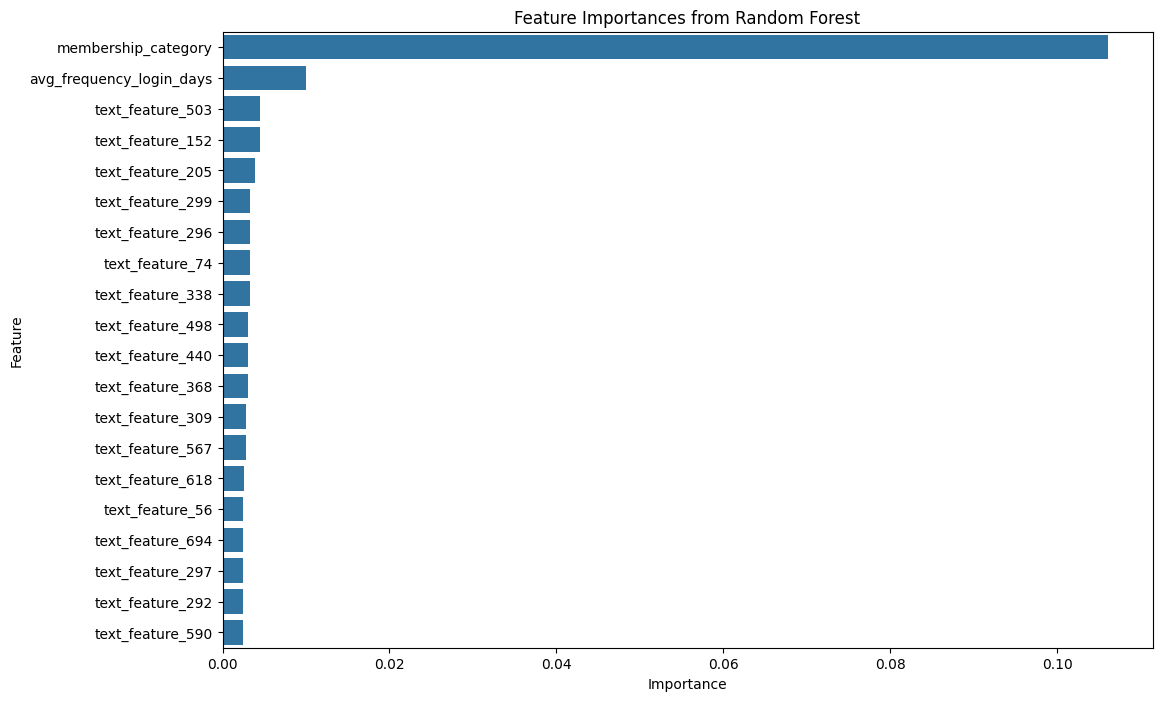

In [ ]:
# Getting feature importances
importances = xgb_model.feature_importances_
feature_names = X_train_vectorized.columns

# Creating a DataFrame for feature importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sorting the DataFrame based on importance and get the top 20 feature importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)[:20]

# Plotting feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


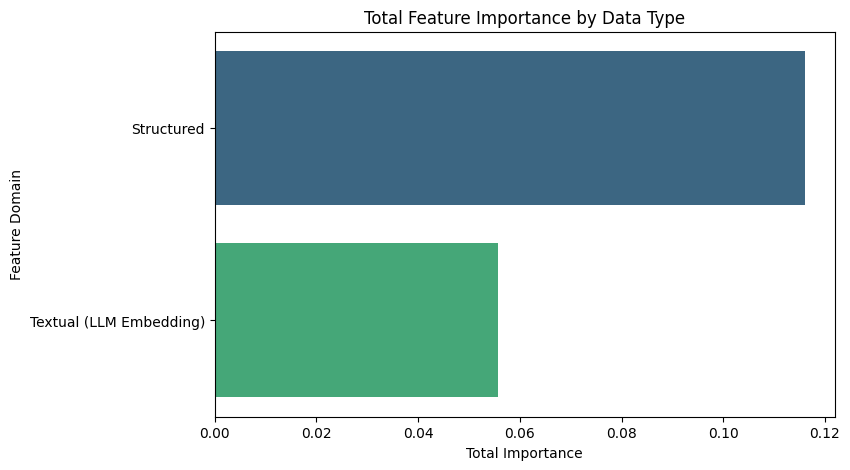

In [ ]:
# Add a column to identify domain
def classify_feature_domain(feature_name):
    if feature_name.startswith("text_feature_"):
        return "Textual (LLM Embedding)"
    else:
        return "Structured"

feature_importance_df['Domain'] = feature_importance_df['Feature'].apply(classify_feature_domain)

# Group and sum importances by domain
domain_importance_df = (
    feature_importance_df
    .groupby('Domain')['Importance']
    .sum()
    .reset_index()
    .sort_values(by='Importance', ascending=False)
)

plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Domain', data=domain_importance_df, palette='viridis')
plt.title('Total Feature Importance by Data Type')
plt.xlabel('Total Importance')
plt.ylabel('Feature Domain')
plt.show()

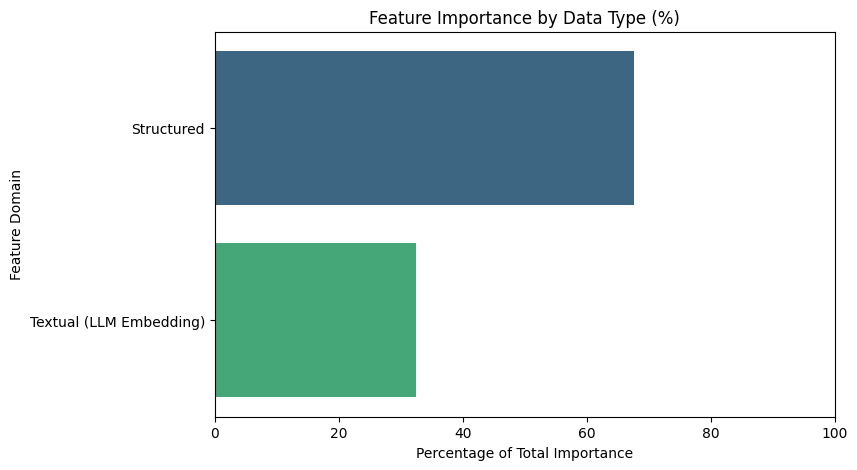

In [ ]:
# Add a column to identify domain
def classify_feature_domain(feature_name):
    if feature_name.startswith("text_feature_"):
        return "Textual (LLM Embedding)"
    else:
        return "Structured"

feature_importance_df['Domain'] = feature_importance_df['Feature'].apply(classify_feature_domain)

# Group and sum importances by domain
domain_importance_df = (
    feature_importance_df
    .groupby('Domain')['Importance']
    .sum()
    .reset_index()
)

# Convert to percentage
domain_importance_df['Importance (%)'] = (domain_importance_df['Importance'] / domain_importance_df['Importance'].sum() * 100).round(2)

# Sort for plotting
domain_importance_df = domain_importance_df.sort_values(by='Importance (%)', ascending=False)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x='Importance (%)', y='Domain', data=domain_importance_df, palette='viridis')
plt.title('Feature Importance by Data Type (%)')
plt.xlabel('Percentage of Total Importance')
plt.ylabel('Feature Domain')
plt.xlim(0, 100)
plt.show()


# 10.0 Personalized Customer Retention: SHAP Analysis Enhanced with LLM Feedback Processing

After choosing a model and obtaining predictions, apply SHAP (Shapley Additive Explanations) to these predictions. SHAP helps in understanding the impact of each feature on the model's prediction for an individual sample. This step is crucial for interpreting model predictions in a human-understandable format. Discuss how SHAP values can uncover the reasoning behind a model's prediction, offering insights into which features contribute most to churn.

In [ ]:
# note: add 1 more sequential chain which interpret sentiment from textual data

api_key = os.getenv('OPENAI_API_KEY')

In [ ]:
import shap
import pandas as pd

# Extract the model from the pipeline
best_model = xgb_model

# Create SHAP TreeExplainer using the extracted model
explainer = shap.TreeExplainer(xgb_model)

In [ ]:
# Calculate SHAP values for the test data (excluding CustomerId)
# This took more than 1 hour to run...
import os
import joblib

shap_output_path = '../../models/shap_output.pkl'

if os.path.exists(shap_output_path):
    # Load precomputed SHAP values
    shap_values, expected_value = joblib.load(shap_output_path)
    print("Loaded SHAP values from cache.")
else:
    # Calculate SHAP values
    shap_values = explainer.shap_values(X_test_vectorized_with_id.drop(columns=['id']))
    expected_value = explainer.expected_value

    # Save SHAP values and base value for reuse
    joblib.dump((shap_values, expected_value), shap_output_path)
    print("SHAP values calculated and saved.")


Loaded SHAP values from cache.


In [ ]:
# Convert SHAP values to DataFrame for easier manipulation
## [:,:,1] means i want to get shap values for positive class...
shap_df = pd.DataFrame(shap_values, columns=X_test_vectorized_with_id.drop(columns=['id']).columns)

# Add 'CustomerId' column to shap_df for alignment
shap_df['id'] = X_test_vectorized_with_id['id'].values

# Initialize a dictionary to store the JSON structures
json_structures = {}

# Generate a JSON structure for each row in shap_df
for index, row in shap_df.iterrows():
    # Create a dictionary for the current row
    row_dict = row.to_dict()

    # Use CustomerId as the key for the JSON structure and remove it from the values
    customer_id = row_dict.pop('id')
    json_structures[customer_id] = row_dict


In [ ]:
from langchain.llms import OpenAI
import time
from langchain_openai.chat_models import ChatOpenAI
from langchain.prompts import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate,
)
from langchain.chains import LLMChain, SequentialChain

In [ ]:
def sort_and_get_top_features(features):
    sorted_features = sorted(features.items(), key=lambda item: abs(item[1]), reverse=True)
    top_features = sorted_features[:10]
    return top_features 

# Create an empty DataFrame
features_shap_values = pd.DataFrame()

# Iterate over each ID key
for id_key, features in json_structures.items():
    sorted_features_df = sort_and_get_top_features(features)
    keys = [key for key, _ in sorted_features_df]
    values = [value for _, value in sorted_features_df]
    features_shap_values = pd.concat([features_shap_values, pd.DataFrame({"ID": id_key,
                                                                          "top10_feature": [keys],
                                                                          "top10_shap_values":[values]})])
                                     
features_shap_values = features_shap_values.reset_index(drop=True)

In [ ]:
# Combine predict and predict_proba in a DataFrame
import pandas as pd
import json

# Predict labels and probabilities
labels = rf_model.predict(X_test_vectorized)
proba = rf_model.predict_proba(X_test_vectorized)

# Create predictions DataFrame
predictions = pd.DataFrame(proba, columns=[f"prediction_score_{cls}" for cls in rf_model.classes_])
predictions.insert(0, "prediction_label", labels)

# Reset index if necessary (to ensure alignment during concat)
X_test_vectorized_with_id = X_test_vectorized_with_id.reset_index(drop=True)
predictions = predictions.reset_index(drop=True)

# Combine features with predictions
combined_df = pd.concat([X_test_vectorized_with_id, predictions], axis=1)

# Convert to JSON (list of dicts)
parsed_json = json.loads(combined_df.to_json(orient='records'))

# Example output
print(parsed_json[:1])

[{'gender_M': 0, 'region_category_Town': 0, 'region_category_Village': 0, 'joined_through_referral_Yes': 0, 'preferred_offer_types_Gift Vouchers/Coupons': 1, 'preferred_offer_types_Without Offers': 0, 'medium_of_operation_Desktop': 1, 'medium_of_operation_Smartphone': 0, 'internet_option_Mobile_Data': 1, 'internet_option_Wi-Fi': 0, 'used_special_discount_Yes': 1, 'offer_application_preference_Yes': 0, 'past_complaint_Yes': 1, 'id': 2, 'year': 4, 'membership_category': 5.0, 'complaint_status': 3.0, 'age': -0.3225616825, 'days_since_last_login': 0.5927148131, 'avg_time_spent': -0.8047866074, 'avg_transaction_value': -0.8451602355, 'avg_frequency_login_days': -0.8803947756, 'points_in_wallet': 0.0337832844, 'text_feature_1': 0.02197793, 'text_feature_2': -0.046620663, 'text_feature_3': -0.03335001, 'text_feature_4': -0.03717942, 'text_feature_5': 0.012610546, 'text_feature_6': -0.005627555, 'text_feature_7': 0.010386296, 'text_feature_8': -0.022074727, 'text_feature_9': -0.03445136, 'text

In [ ]:
def prepare_input_data(user_id, parsed_json, json_structures):
    desired_data = next(item for item in parsed_json if item['id'] == int(user_id))

    # get features from parsed_json, but exclude the text features
    meta_data = {
        'id': desired_data['id'],
        'gender_M': desired_data['gender_M'],
        'region_category_Town': desired_data['region_category_Town'],
        'region_category_Village': desired_data['region_category_Village'],
        'joined_through_referral_Yes': desired_data['joined_through_referral_Yes'],
        'preferred_offer_types_Gift Vouchers/Coupons': desired_data['preferred_offer_types_Gift Vouchers/Coupons'],
        'preferred_offer_types_Without Offers': desired_data['preferred_offer_types_Without Offers'],
        'medium_of_operation_Desktop': desired_data['medium_of_operation_Desktop'],
        'medium_of_operation_Smartphone': desired_data['medium_of_operation_Smartphone'],
        'internet_option_Mobile_Data': desired_data['internet_option_Mobile_Data'],
        'internet_option_Wi-Fi': desired_data['internet_option_Wi-Fi'],
        'used_special_discount_Yes': desired_data['used_special_discount_Yes'],
        'offer_application_preference_Yes': desired_data['offer_application_preference_Yes'],
        'past_complaint_Yes': desired_data['past_complaint_Yes'],
        'year': desired_data['year'],
        'membership_category': desired_data['membership_category'],
        'complaint_status': desired_data['complaint_status'],
        'age': desired_data['age'],
        'days_since_last_login': desired_data['days_since_last_login'],
        'avg_time_spent': desired_data['avg_time_spent'],
        'avg_transaction_value': desired_data['avg_transaction_value'],
        'avg_frequency_login_days': desired_data['avg_frequency_login_days'],
        'points_in_wallet': desired_data['points_in_wallet'],
    }

    print('metadata:')
    print(meta_data)
    print('\n')

    # get predicted_label from parsed_json
    result = desired_data['prediction_label']
    
    shap_values = json_structures[int(user_id)]
    
    return meta_data, result, shap_values

In [ ]:
from langchain.chains import ConversationChain

In [ ]:

def generate_churn_explainability(meta_data: dict, 
                                  result: int, shap_values: dict, 
                                  ## input the customer feedback if you want to perform text analysis on customer feedback via LLM
                                  customer_feedback: str):

    # Create Model
    llm = ChatOpenAI(model ="gpt-4.1-mini", temperature=0.4, openai_api_key = api_key)
    
    columns = ['gender_M', 'region_category_Town', 'region_category_Village', 'joined_through_referral_Yes', 
            'preferred_offer_types_Gift Vouchers/Coupons', 'preferred_offer_types_Without Offers',
            'medium_of_operation_Desktop', 'medium_of_operation_Smartphone', 'internet_option_Mobile_Data', 
            'internet_option_Wi-Fi', 'used_special_discount_Yes', 'offer_application_preference_Yes',
            'past_complaint_Yes', 'year', 'membership_category', 'complaint_status', 'age', 'days_since_last_login', 
            'avg_time_spent', 'avg_transaction_value', 'avg_frequency_login_days', 'points_in_wallet'
    ]

    # Get columns  for user 
    template0 = "Explain the significance and potential usage of the following data columns in a dataset: {columns}. \
                  Provide a simple description for each column."
    prompt0 = ChatPromptTemplate.from_template(template0)
    chain_0 = LLMChain(llm=llm,
                   prompt=prompt0,
                   output_key="column_descriptions")


    # Template 1: Get meta data description for user 
    template1 = "Explain {meta_data} based on the information provided by {column_descriptions}."
    prompt1 = ChatPromptTemplate.from_template(template1)
    chain_1 = LLMChain(llm=llm,
                       prompt=prompt1,
                       output_key="meta_data_description")

    # Template 2: Get explainability for the user
    system_template = "You are a churn problem explainability assistant. Your goal is to understand the  complexities\
                       of customer loss and uncover why customers are leaving a service or product in business models.\
                       The explanations should be simple and understandable for users to analyze."
    system_message_prompt = SystemMessagePromptTemplate.from_template(system_template)

    human_template = "The churn result of a customer, which is {result} value has been obtained in a machine\
                     learning model using the {meta_data_description}. The {shap_values} represent the Shapley\
                     values for each feature, indicating why the model produced this particular result. Shapley\
                     values provide insights into the contribution of each feature to the final prediction. \
                     Explain why such a result was obtained in a way that the user can understand. Don't explain\
                     what the Shapley value is in a technical manner, using language that a non-technical\
                     person can understand. Maximum text length should be 200 words. Provide a concise explanation\
                     without using the phrase 'based on."
    human_message_prompt = HumanMessagePromptTemplate.from_template(human_template)
    prompt2 = ChatPromptTemplate.from_messages([system_message_prompt, human_message_prompt])
    chain_2 = LLMChain(llm=llm,
                       prompt=prompt2,
                       output_key="explanation")

    ## Template 3: 
    template3 = "Identify the main pain points, complaints, or issues mentioned in this customer feedback: {customer_feedback}. \
            Extract the specific problems the customer is experiencing and categorize them (e.g., product issues, \
            service problems, pricing concerns, usability issues)."
    prompt3 = ChatPromptTemplate.from_template(template3)
    chain_3 = LLMChain(llm=llm,
                           prompt=prompt3,
                           output_key="sentiment")
    
    # Template 4: 
    template4 = "Provide strategies based on {explanation} to prevent user loss. Explain in language that a non-technical \
                 person can understand. Maximum text length should be 200 words. Provide a concise explanation without using the \
                 phrase 'based on."
    prompt4 = ChatPromptTemplate.from_template(template4)
    chain_4 = LLMChain(llm=llm,
                       prompt=prompt4,
                       output_key="recommendation")
    

    # Define the  chain of operations with the new chain
    seq_chain = SequentialChain(chains=[chain_0, chain_1, chain_2, chain_3, chain_4],
                                input_variables=['columns', 'meta_data', 'result', 'shap_values', 'customer_feedback'],
                                output_variables=['column_descriptions', 'meta_data_description', 
                                                  'explanation', 'sentiment', 'recommendation'],
                                verbose=True)

    input_data = {
        'columns': columns,
        'meta_data': meta_data,
        'result': result,
        'shap_values': shap_values,
        'customer_feedback': customer_feedback
    }

    output = seq_chain.invoke(input_data)

    return output

- Explanation of user-profile & Recommendation to retain a single customer from being churn

In [ ]:
sample_customer_id = 9809
customer_feedback = X_test[X_test.id == sample_customer_id]['feedback'].iloc[0]

meta_datas, results, shap_valuess = prepare_input_data(sample_customer_id, parsed_json, json_structures)
churn_explainability_sample_1 = generate_churn_explainability(meta_datas, results, shap_valuess, customer_feedback)
idx = features_shap_values.loc[features_shap_values.ID == sample_customer_id].index
features_shap_values.loc[idx,'explanation'] = churn_explainability_sample_1['explanation']
features_shap_values.loc[idx, 'sentiment'] = churn_explainability_sample_1['sentiment']
features_shap_values.loc[idx, 'recommendation'] = churn_explainability_sample_1['recommendation']

time.sleep(60)

metadata:
{'id': 9809, 'gender_M': 0, 'region_category_Town': 0, 'region_category_Village': 0, 'joined_through_referral_Yes': 0, 'preferred_offer_types_Gift Vouchers/Coupons': 0, 'preferred_offer_types_Without Offers': 1, 'medium_of_operation_Desktop': 0, 'medium_of_operation_Smartphone': 1, 'internet_option_Mobile_Data': 0, 'internet_option_Wi-Fi': 1, 'used_special_discount_Yes': 1, 'offer_application_preference_Yes': 0, 'past_complaint_Yes': 1, 'year': 6, 'membership_category': 2.0, 'complaint_status': 2.0, 'age': 1.3160171814, 'days_since_last_login': -0.504644325, 'avg_time_spent': -1.1768731286, 'avg_transaction_value': -0.7263516166, 'avg_frequency_login_days': 0.4667324638, 'points_in_wallet': 0.0966608749}




> Entering new SequentialChain chain...

> Finished chain.


In [ ]:
from IPython.display import display, Markdown

# Customer demographic info
display(Markdown(f"### Column descriptions\n{churn_explainability_sample_1['column_descriptions']}"))
## display(Markdown(f"### Metadata description\n{churn_explainability_sample_1['meta_data_description']}"))

### Column descriptions
Certainly! Here's a simple description and potential significance for each of the listed data columns:

1. **gender_M**  
   - Description: Indicates if the customer is male (1 if male, 0 otherwise).  
   - Usage: Useful for gender-based segmentation or analysis.

2. **region_category_Town**  
   - Description: Indicates if the customer is from a town (1 if yes, 0 otherwise).  
   - Usage: Helps analyze customer behavior based on geographic location.

3. **region_category_Village**  
   - Description: Indicates if the customer is from a village (1 if yes, 0 otherwise).  
   - Usage: Similar to above, for rural area segmentation.

4. **joined_through_referral_Yes**  
   - Description: Indicates if the customer joined via referral (1 if yes, 0 otherwise).  
   - Usage: Useful to measure the impact of referral programs.

5. **preferred_offer_types_Gift Vouchers/Coupons**  
   - Description: Indicates if the customer prefers gift vouchers or coupons (1 if yes, 0 otherwise).  
   - Usage: Helps tailor marketing campaigns based on offer preferences.

6. **preferred_offer_types_Without Offers**  
   - Description: Indicates if the customer prefers no offers (1 if yes, 0 otherwise).  
   - Usage: Identifies customers who might not respond well to promotions.

7. **medium_of_operation_Desktop**  
   - Description: Indicates if the customer primarily uses a desktop (1 if yes, 0 otherwise).  
   - Usage: Helps understand device preferences for user experience optimization.

8. **medium_of_operation_Smartphone**  
   - Description: Indicates if the customer primarily uses a smartphone (1 if yes, 0 otherwise).  
   - Usage: Similar to above, for mobile-focused strategies.

9. **internet_option_Mobile_Data**  
   - Description: Indicates if the customer uses mobile data for internet (1 if yes, 0 otherwise).  
   - Usage: Can affect app performance and marketing timing.

10. **internet_option_Wi-Fi**  
    - Description: Indicates if the customer uses Wi-Fi for internet (1 if yes, 0 otherwise).  
    - Usage: Similar to above, may affect engagement patterns.

11. **used_special_discount_Yes**  
    - Description: Indicates if the customer has used a special discount (1 if yes, 0 otherwise).  
    - Usage: Helps identify discount-sensitive customers.

12. **offer_application_preference_Yes**  
    - Description: Indicates if the customer prefers applying offers (1 if yes, 0 otherwise).  
    - Usage: Useful to target customers who actively use offers.

13. **past_complaint_Yes**  
    - Description: Indicates if the customer has made a complaint in the past (1 if yes, 0 otherwise).  
    - Usage: Important for customer satisfaction and retention analysis.

14. **year**  
    - Description: The year when the data was recorded or the customer joined.  
    - Usage: Useful for time series or cohort analysis.

15. **membership_category**  
    - Description: Type or level of membership (e.g., Silver, Gold, Platinum).  
    - Usage: Helps understand customer loyalty and benefits.

16. **complaint_status**  
    - Description: Status of any complaint (e.g., resolved, unresolved).  
    - Usage: Important for customer service performance tracking.

17. **age**  
    - Description: Age of the customer.  
    - Usage: Useful for demographic segmentation.

18. **days_since_last_login**  
    - Description: Number of days since the customer last logged in.  
    - Usage: Indicator of customer engagement and activity.

19. **avg_time_spent**  
    - Description: Average time spent on the platform per session (likely in minutes).  
    - Usage: Measures user engagement.

20. **avg_transaction_value**  
    - Description: Average monetary value of transactions made by the customer.  
    - Usage: Helps identify high-value customers.

21. **avg_frequency_login_days**  
    - Description: Average number of days between logins.  
    - Usage: Another engagement metric.

22. **points_in_wallet**  
    - Description: Loyalty or reward points currently held by the customer.  
    - Usage: Useful for loyalty program analysis and targeting promotions.

---

These columns collectively provide demographic, behavioral, and transactional insights useful for customer segmentation, targeted marketing, retention strategies, and overall business analytics.

In [ ]:
display(Markdown(f"### Explanation\n{churn_explainability_sample_1['explanation']}"))

### Explanation
The model predicted that this customer will likely stay (churn = 0). Key reasons include their mid-level membership, which strongly supports retention. Their recent logins and frequent visits also contribute positively, showing ongoing engagement. Although they spend less time per visit and have lower transaction amounts, their steady login frequency and some loyalty points help keep them connected. The customer’s preference to avoid broad offers but use special discounts suggests they respond well to selective deals, which helps maintain interest. Past complaints slightly raise concern but don’t outweigh the positive factors. Using a smartphone on Wi-Fi and being from an urban area also align with continued usage patterns. Overall, the combination of steady engagement, mid-tier membership, and selective discount use encourages the model to predict this customer will not leave.

In [ ]:
display(Markdown(f"### Original Customer feedback Text\n{customer_feedback}"))
display(Markdown(f"### Sentiment\n{churn_explainability_sample_1['sentiment']}"))

### Original Customer feedback Text
I’ve been using your website for a while now, and I have to say it’s really frustrating to navigate. Coming from a small village, I’m not the most tech-savvy, and the layout just feels cluttered and confusing. I spend a lot of time on the site trying to find what I need, and even though I’ve made purchases worth a good amount, the experience could be so much better. I’ve raised this issue before, and while it was addressed in follow-up, I still feel the website needs a major overhaul to make it more user-friendly.

### Sentiment
**Extracted Problems and Categorization:**

1. **Usability Issues:**
   - Website is frustrating to navigate.
   - Layout feels cluttered and confusing.
   - Difficulty finding needed information or products.
   - Overall user experience is poor and not user-friendly.
   
2. **Service Problems:**
   - Previous feedback was acknowledged but the issue persists.
   - Customer feels the website needs a major overhaul, implying insufficient improvements after prior complaints.

**Summary:**  
The main pain points are related to **usability issues** (complex navigation, cluttered layout, confusing interface) and **service problems** (inadequate resolution of previously raised concerns). There are no mentions of product quality or pricing concerns.

In [ ]:
display(Markdown(f"### Recommendation\n{churn_explainability_sample_1['recommendation']}"))

### Recommendation
This customer is likely to stay because they have a solid, mid-level membership and regularly log in and visit the service, showing they are engaged. Even though they spend less time each visit and don’t spend a lot of money, they still log in consistently and have earned some loyalty points, which keeps them connected. They prefer special discounts over broad offers, so giving them selective deals can keep their interest alive. While they have made some complaints in the past, it hasn’t been enough to push them away. They use a smartphone on Wi-Fi and live in an urban area, which fits well with continued use. To keep this customer happy and prevent them from leaving, it’s best to focus on offering personalized special discounts, encourage steady engagement through regular updates or reminders, and address any complaints quickly to maintain trust. Strengthening their mid-level membership benefits could also make them feel more valued and less likely to leave.

In [ ]:
# the result is saved to the pandas dataframe as well
features_shap_values[features_shap_values.ID == sample_customer_id]

,ID,top10_feature,top10_shap_values,explanation,sentiment,recommendation
1905,9809.0,"[avg_frequency_login_days, membership_category...","[-4.380711078643799, -1.9834233522415161, 0.19...",The model predicted that this customer will li...,**Extracted Problems and Categorization:**\n\n...,This customer is likely to stay because they h...
